****
## **PREDICTING SAFE DRIVERS**
****

## Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import scipy.stats as stats 
from sklearn.datasets import make_classification

# Feature Engineering & Selection
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Train test split
from sklearn.model_selection import train_test_split

#Classification models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

# Ensemble methods
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from mlxtend.classifier import StackingClassifier

# Model Evaluation
from sklearn.metrics import accuracy_score , roc_auc_score, auc, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

#Resampling
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Tuning hypreprameters
from sklearn.model_selection import RandomizedSearchCV

#Other
from time import time
from scipy.stats import ttest_ind

#Ploting
from matplotlib import pyplot as plt
%matplotlib inline
sns.set_style("white")
pd.options.display.float_format = "{:.3f}".format

from matplotlib.ticker import MaxNLocator
from collections import namedtuple
import matplotlib as mpl
mpl.rcParams["figure.dpi"]= 300

#Suppressing Warnings
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
warnings.simplefilter("ignore")

 ## **Dataset Loading**

In [2]:
# import the file 
safe_driver = pd.read_excel("C:\\Users\\shwet\\Downloads\\IT_3.xlsx\\IT_3.xlsx")

## **Data Exploration**

In [3]:
# Check if there are any Null data that need to be dropped
safe_driver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30240 entries, 0 to 30239
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            30240 non-null  int64  
 1   target                        30240 non-null  int64  
 2   Gender                        30240 non-null  object 
 3   EngineHP                      30240 non-null  int64  
 4   credit_history                30240 non-null  int64  
 5   Years_Experience              30240 non-null  int64  
 6   annual_claims                 30240 non-null  int64  
 7   Marital_Status                30240 non-null  object 
 8   Vehical_type                  30240 non-null  object 
 9   Miles_driven_annually         30232 non-null  float64
 10  size_of_family                30240 non-null  int64  
 11  Age_bucket                    30240 non-null  object 
 12  EngineHP_bucket               30240 non-null  object 
 13  Y

In [4]:
safe_driver.describe()

,ID,target,EngineHP,credit_history,Years_Experience,annual_claims,Miles_driven_annually,size_of_family
count,30240.000,30240.000,30240.000,30240.000,30240.000,30240.000,30232.000,30240.000
mean,15120.500,0.708,196.604,685.770,13.256,1.138,17422.939,4.521
std,8729.680,0.455,132.347,102.454,9.890,1.083,17483.783,2.287
min,1.000,0.000,80.000,300.000,1.000,0.000,5000.000,1.000
25%,7560.750,0.000,111.000,668.000,5.000,0.000,9668.500,3.000
50%,15120.500,1.000,141.000,705.000,10.000,1.000,12280.000,5.000
75%,22680.250,1.000,238.000,753.000,20.000,2.000,14697.250,7.000
max,30240.000,1.000,1005.000,850.000,40.000,4.000,99943.000,8.000


### **Data Visualization** 

**Distribution of 'credit_history'**

In [5]:
from scipy import stats
x, _ = stats.boxcox(safe_driver["credit_history"])

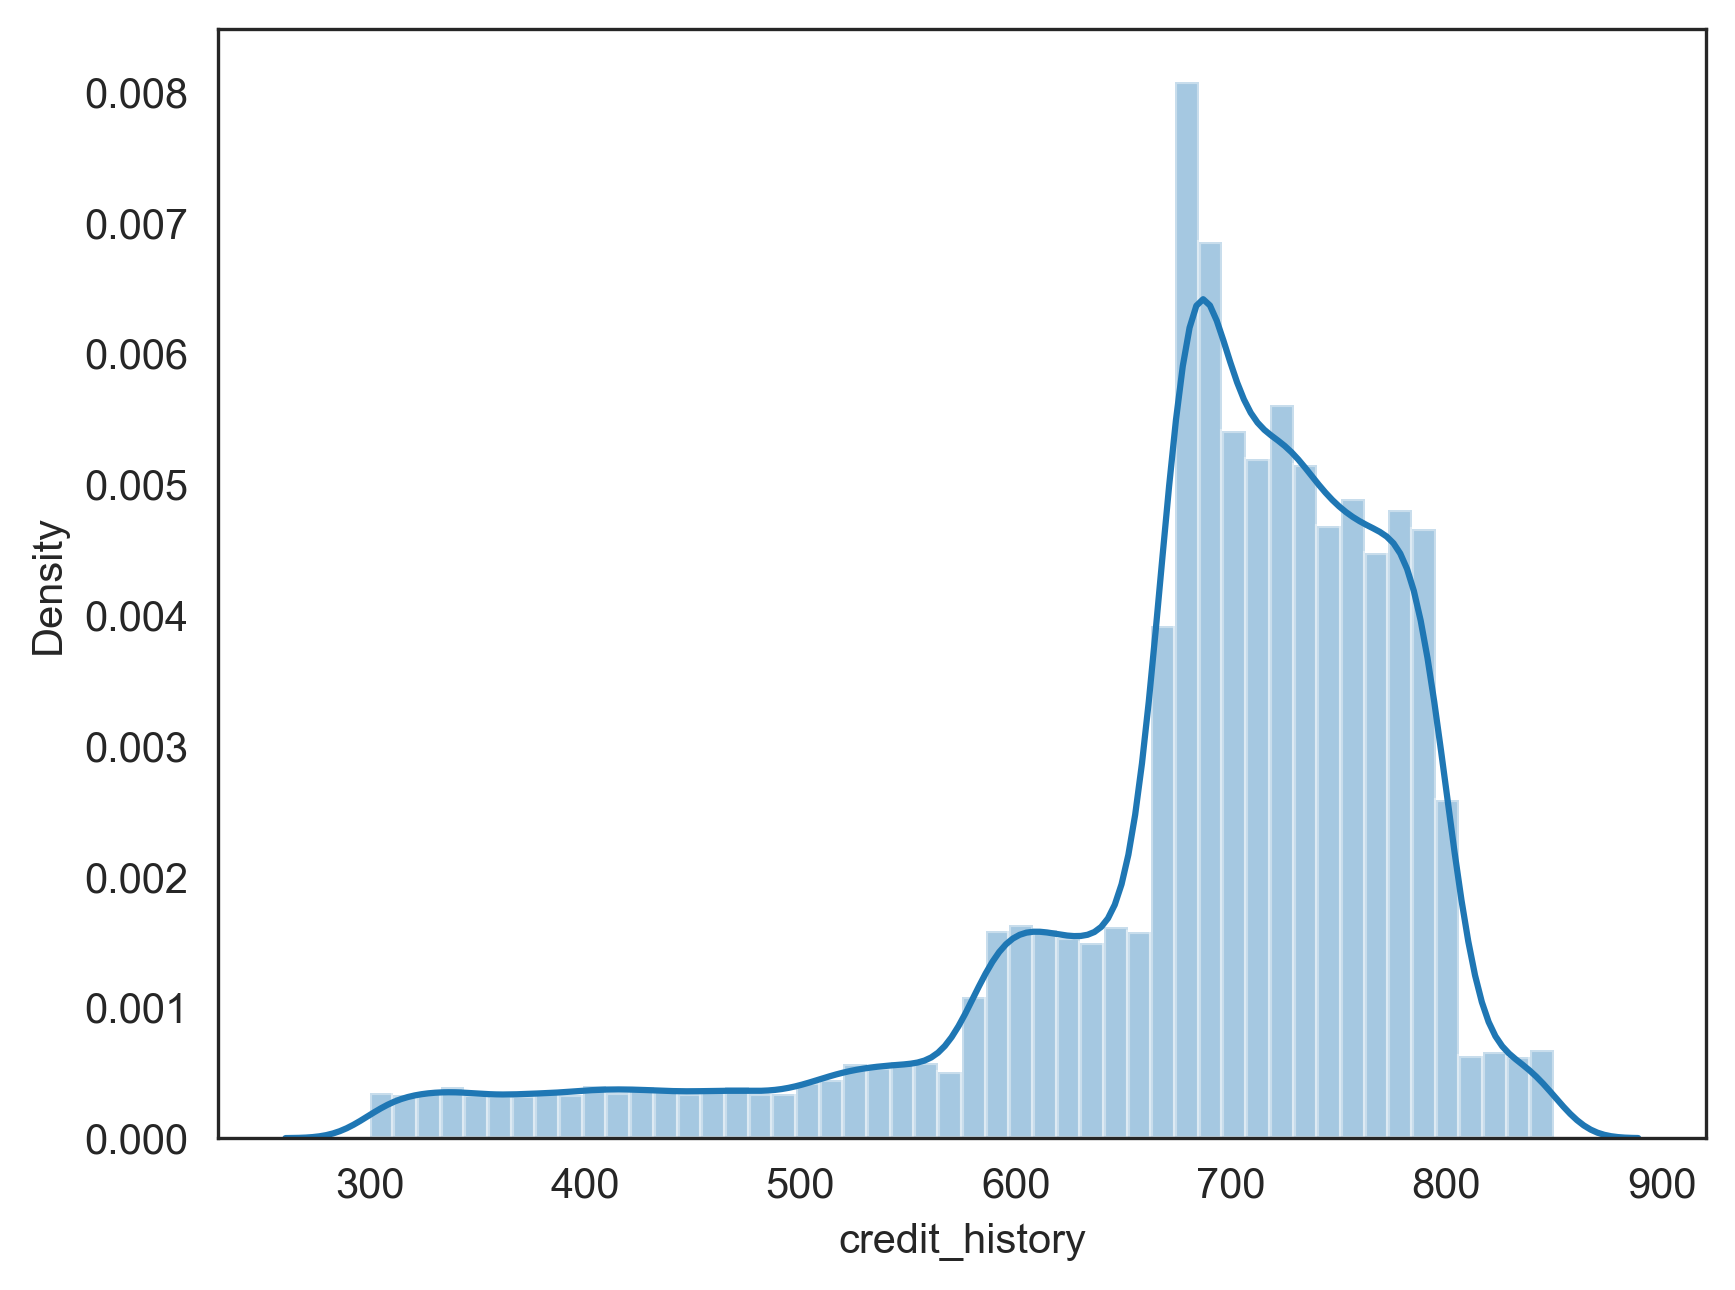

In [6]:
ax = sns.distplot(safe_driver.credit_history)

### **Class Distribution** 

In [7]:
#Check and see if we have an imbalanced class label in the dataset
# Calculate the percentage of sucess data("target" ==1) with respect to the failure data ("target" ==0)

true_claims = (safe_driver["target"] == 1).sum()
print("True Claims is {}".format(true_claims))

total_records = len(safe_driver["target"])
print("Total number of records is {}".format(total_records ))

print("The percentage of true claims is {}%".format(
round(true_claims / total_records * 100), 2))


True Claims is 21396
Total number of records is 30240
The percentage of true claims is 71%


Our dataset is inddedd imbalanced. we will balance it later using SMOTE technique.

#### Separate categorical data from dataset

The dataset contains several categorical data that ends with _bucket that need to be either dropped or converted to numerical values using dummies.

1. Converted to numeric using dummies
2. Dropped 
3. Assigned a binary value

#### Identify Categorical Features

In [8]:
cat_features = safe_driver.select_dtypes(include=["object"]).copy()
print(cat_features.columns)

Index(['Gender', 'Marital_Status', 'Vehical_type', 'Age_bucket',
       'EngineHP_bucket', 'Years_Experience_bucket',
       'Miles_driven_annually_bucket', 'credit_history_bucket', 'State'],
      dtype='object')


Among the categorical variables we retain the following:

1. Gender
2. Marital_Satus 
3. Vehicle_Type
4. Age_bucket

EngineHp_bucket, Years_Experience_bucket, Miles_driven_annually_bucket, cerdit_history_bucket have a corresponding continus variable.Creating each with their own dummines along with the continuous variable does not make sense. we will keep the Age_bucket as there is no continus varaible to represent age.

we can split the dataset by sate and analyze each state by itself. As each US state has its own regulations it may make sense to analyse each state by itself. we could aggregate our results across states later to get a national statistic.

or for now we could drop the state column and analyze the data across the nation later.

## **Data Cleaning**

In [9]:
#Drop these 5 columns: ID,EngineHP_bucket,Years_Experience_bucket,Miles_driven_annually_bucket,credit_history_bucket
safe_driver.drop(['ID','EngineHP_bucket','Years_Experience_bucket','Miles_driven_annually_bucket','credit_history_bucket'], axis=1, inplace=True) 

In [10]:
#Check if the dataset has any NaN values 
safe_driver.isnull().sum()

target                   0
Gender                   0
EngineHP                 0
credit_history           0
Years_Experience         0
annual_claims            0
Marital_Status           0
Vehical_type             0
Miles_driven_annually    8
size_of_family           0
Age_bucket               0
State                    0
dtype: int64

The Miles_driven_annually feature has some null values. Let us explore which particular cells have NaN and ingest them with the median data.

In [11]:
safe_driver[safe_driver.isnull().any(axis=1)]

,target,Gender,EngineHP,credit_history,Years_Experience,annual_claims,Marital_Status,Vehical_type,Miles_driven_annually,size_of_family,Age_bucket,State
1235,1,F,124,793,27,0,Married,Truck,NaN,3,>40,NJ
7365,0,F,465,696,5,0,Married,Truck,NaN,8,18-27,SD
11464,1,F,137,787,18,1,Married,Truck,NaN,1,>40,CT
18158,0,F,108,747,8,1,Married,Truck,NaN,1,18-27,OR
19795,1,F,121,774,19,0,Married,Truck,NaN,2,28-34,NY
25731,1,F,355,694,15,1,Married,Truck,NaN,5,28-34,CT
26512,1,F,109,743,40,0,Married,Truck,NaN,1,>40,OR
27045,1,F,83,784,21,0,Married,Truck,NaN,1,>40,CT


It may make sense to ingest the median of Vehicle_Type == "Truck" as all the NaN values are for Truck only. Let us look at the median of Miles_driven_annually by each vehicle type.

**checking duplicate values**

In [12]:
# check if there is any duplicate value 
safe_driver.duplicated().sum()

0

#### Handle Missing Values 

*Imputing missing values in 'Miles_driven_annually'*

In [13]:
median_values = safe_driver.groupby('Vehical_type')['Miles_driven_annually'].median()
median_values

Vehical_type
Car       13147.500
Truck     12370.500
Utility   11117.000
Van       11272.000
Name: Miles_driven_annually, dtype: float64

In [14]:
print(median_values.head())
print(median_values.index)


Vehical_type
Car       13147.500
Truck     12370.500
Utility   11117.000
Van       11272.000
Name: Miles_driven_annually, dtype: float64
Index(['Car', 'Truck', 'Utility', 'Van'], dtype='object', name='Vehical_type')


In [15]:
# Replace NaN values in Miles_driven_annually with the median value for Truck
#There may be better ways to impute missing data. But we have just 8 NaN cells out of some 30,000 plus rows which is less than 0.03%
#So, imputing with median for all the 8 cells is not going to skew our results.
truck_median = median_values.loc["Truck"]


In [16]:
safe_driver.loc[
    (safe_driver["Vehical_type"] == "Truck") & (safe_driver["Miles_driven_annually"].isna()),
    "Miles_driven_annually"
] = truck_median

In [17]:
print(truck_median)

12370.5


In [18]:
#check for null values again to make sure we did not miss any accidentally
safe_driver[safe_driver.isnull().any(axis=1)]

,target,Gender,EngineHP,credit_history,Years_Experience,annual_claims,Marital_Status,Vehical_type,Miles_driven_annually,size_of_family,Age_bucket,State


In [19]:
safe_driver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30240 entries, 0 to 30239
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   target                 30240 non-null  int64  
 1   Gender                 30240 non-null  object 
 2   EngineHP               30240 non-null  int64  
 3   credit_history         30240 non-null  int64  
 4   Years_Experience       30240 non-null  int64  
 5   annual_claims          30240 non-null  int64  
 6   Marital_Status         30240 non-null  object 
 7   Vehical_type           30240 non-null  object 
 8   Miles_driven_annually  30240 non-null  float64
 9   size_of_family         30240 non-null  int64  
 10  Age_bucket             30240 non-null  object 
 11  State                  30240 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 2.8+ MB


Looking at the feature values above the range of values of each vary a lot. for example "Miles_driven_annually" is in the 10s of thousanda, whereas "credit_history" is in the 100s and "annunal_claims" is in single digit. Due to the varying magnitudes of the feature values we will scale the fatures with Z-scores using sklearn.preprocessing.scale.

### **Data Separation**

In [20]:
# To standardize the numeric features we need to isloate them first into a separate dataframe
safe_driver_num_features = safe_driver.drop(safe_driver.select_dtypes(['object']), axis=1)
safe_driver_num_features.drop(['target'], axis=1, inplace=True)
safe_driver_cat_features = safe_driver.select_dtypes(['object'])

In [21]:
# Check if there are any NaN values one more time
safe_driver_num_features[safe_driver_num_features.isnull().any(axis=1)]

,EngineHP,credit_history,Years_Experience,annual_claims,Miles_driven_annually,size_of_family


### Feature Scaling

In [22]:
# Restore  the cloumns name from original dataset
safe_driver_scaled = pd.DataFrame(preprocessing.scale(safe_driver_num_features),
                                  columns=safe_driver_num_features.columns)

# We now have the scaled feature set. Now we need to concatenate the categorical features back with our scaled.
#dataset before running OneHotEncoder or dummies.

In [23]:
# We will concatenate the scaled dataframe with the categorical feature set 
safe_driver = pd.concat(
    [safe_driver_scaled, safe_driver["target"], safe_driver_cat_features], axis=1)

# We will add the 'target' label back to the scaled dataframe as we may need it later
safe_driver_scaled = pd.concat(
    [safe_driver_scaled, safe_driver["target"]],axis=1)

In [24]:
safe_driver.head(10)

,EngineHP,credit_history,Years_Experience,annual_claims,Miles_driven_annually,size_of_family,target,Gender,Marital_Status,Vehical_type,Age_bucket,State
0,2.459,-0.291,-1.239,-1.051,-0.153,0.209,1,F,Married,Car,<18,IL
1,3.736,0.178,0.277,-1.051,-0.116,0.647,1,F,Married,Car,28-34,NJ
2,-0.481,0.051,0.176,-1.051,-0.427,-0.665,1,M,Married,Van,>40,CT
3,-0.382,0.334,-0.430,-1.051,3.427,-0.665,1,M,Married,Van,18-27,CT
4,-0.518,0.832,1.996,-0.128,-0.185,-0.228,1,M,Married,Van,>40,WY
5,-0.397,0.354,0.480,-0.128,-0.298,1.521,1,F,Married,Truck,>40,DE
6,-0.345,0.998,1.794,1.719,-0.198,-1.103,1,F,Married,Truck,>40,NJ
7,-0.821,0.598,0.783,-0.128,-0.184,0.209,1,F,Single,Car,>40,ME
8,3.449,0.305,2.097,-1.051,-0.019,-1.540,1,F,Married,Car,>40,CA
9,-0.579,0.969,0.581,-0.128,-0.648,-1.540,0,F,Married,Truck,35-40,NJ


### **Visualize Data Relationships**

let us data visualization techniques to find the distribution of the features and also the correlation between different features. We could, may be drop one or two more features based on distribution or correlation making our dataset cleanser.

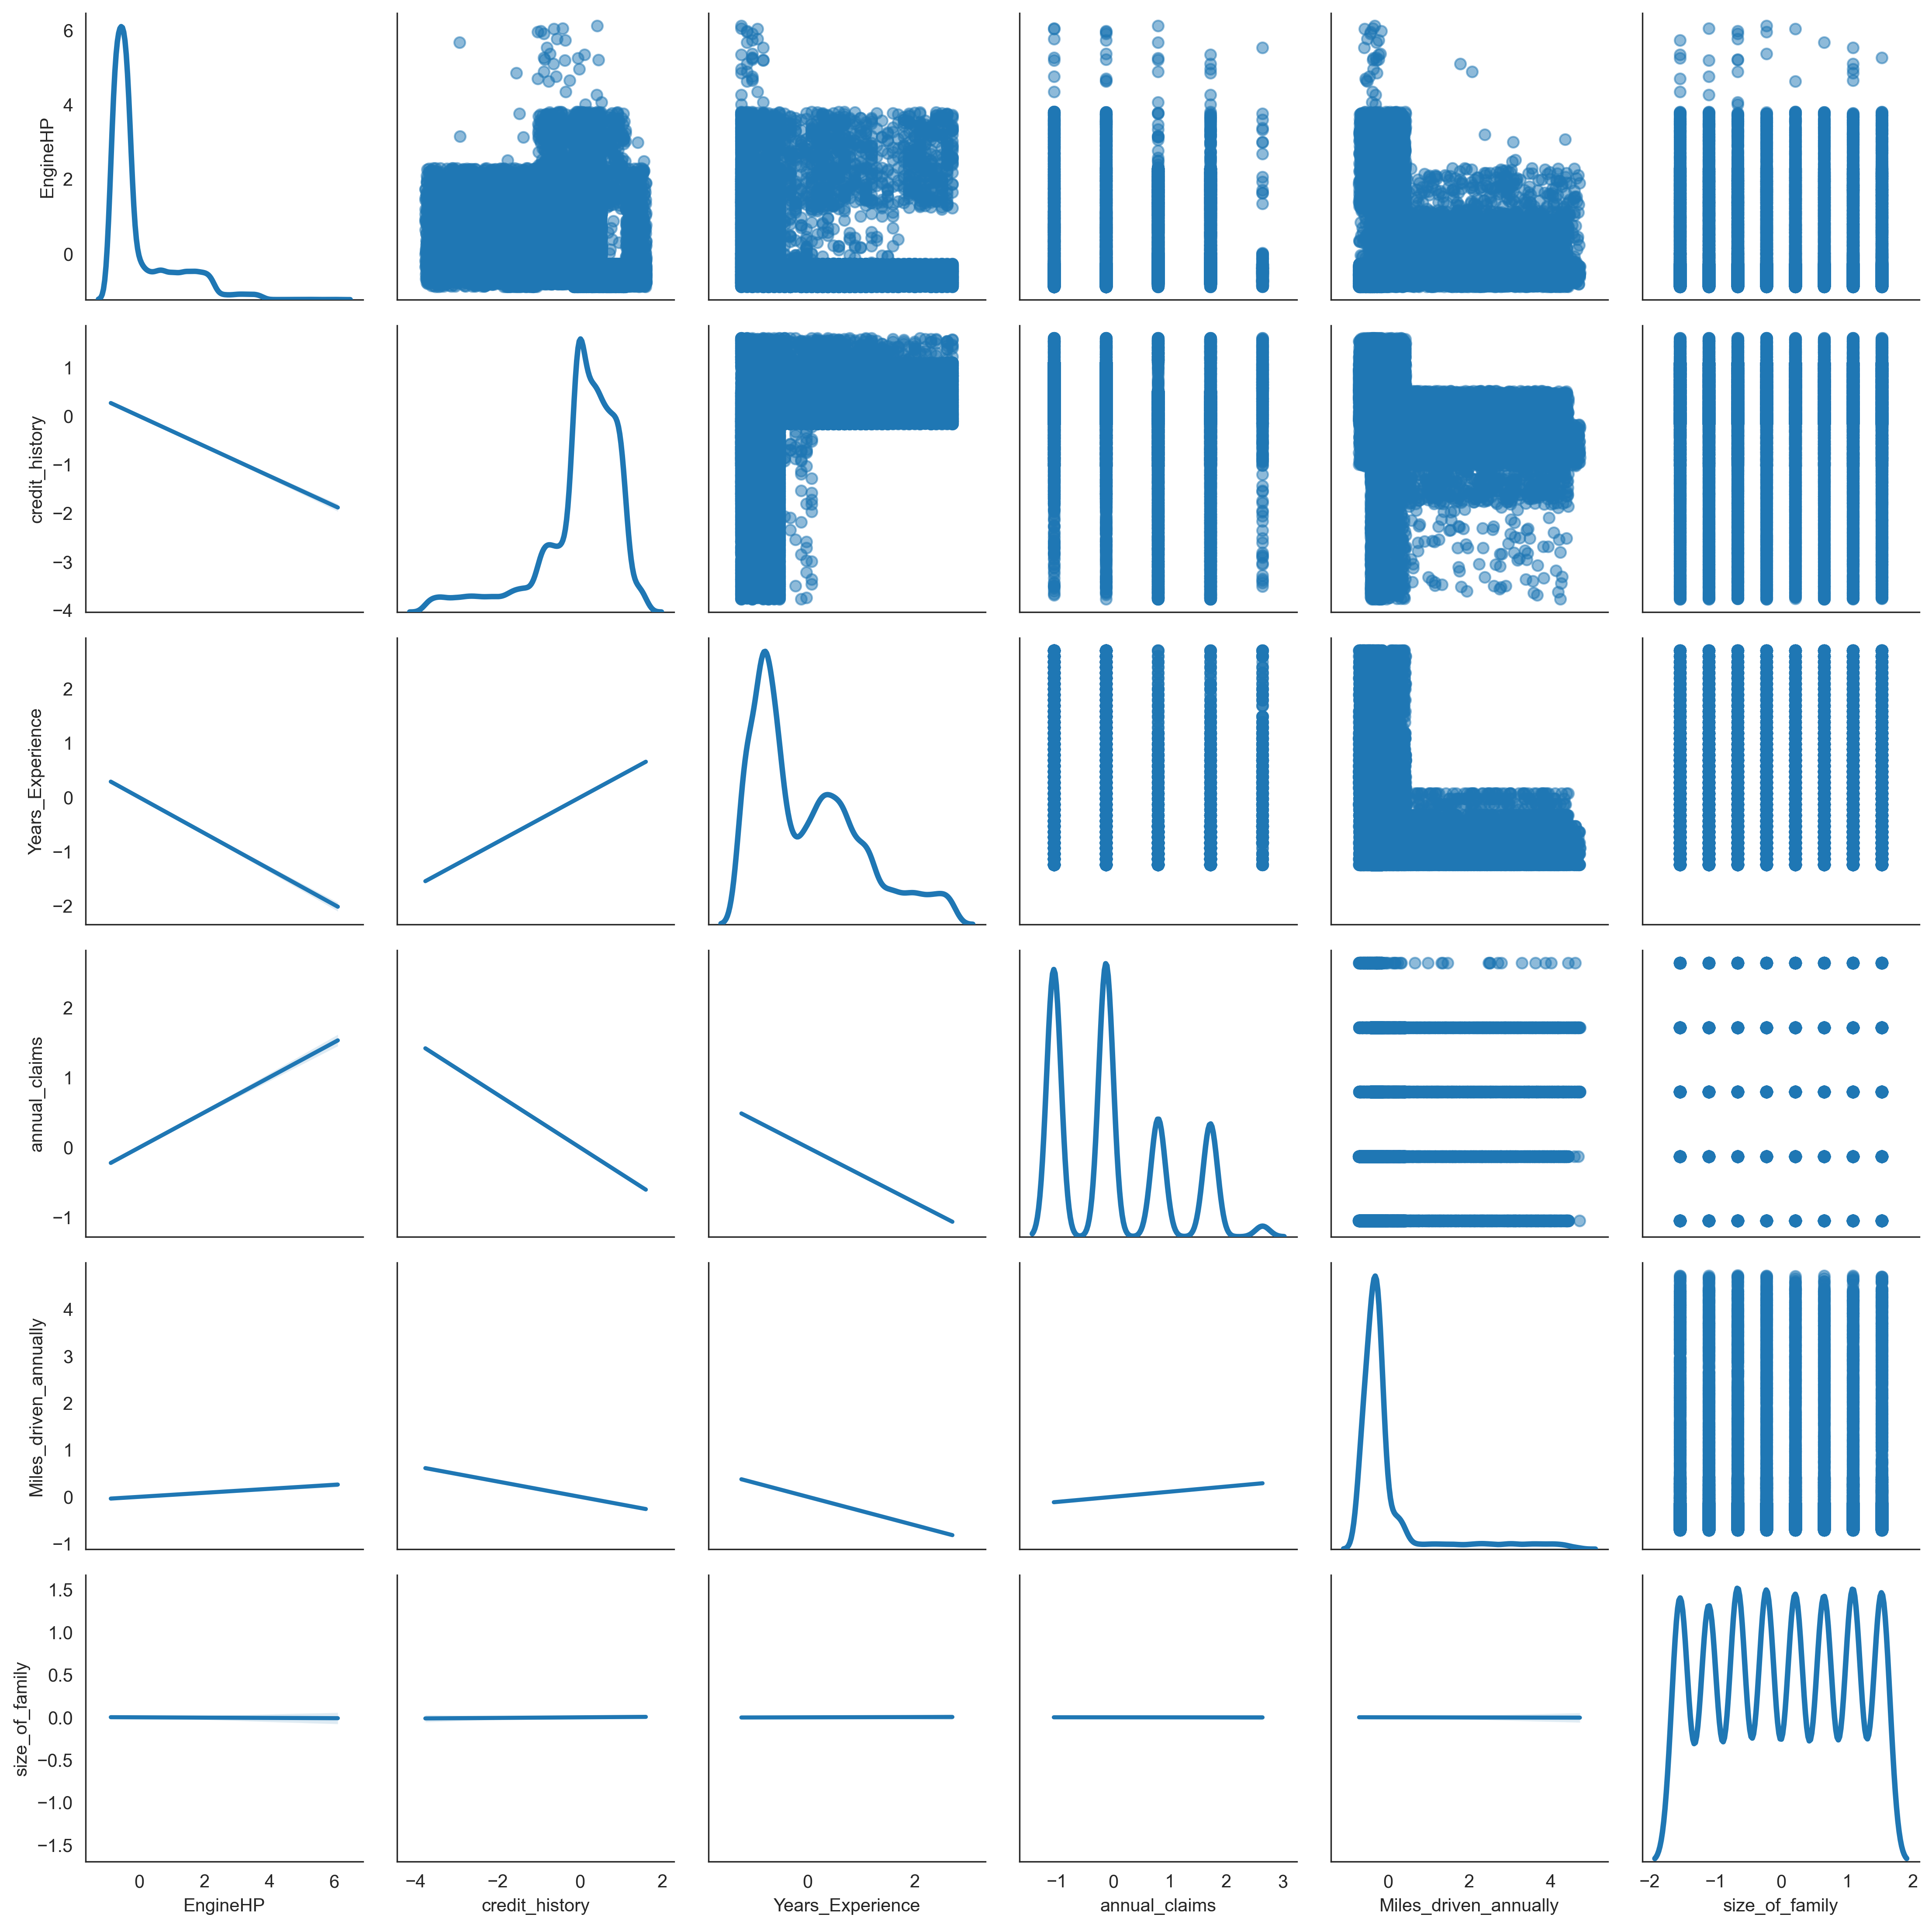

In [25]:
# Create a scatterplot materix that shows all the bivariate relationships in one plot made up of subplots.
# Let us drop the 'target' variable
safe_driver_copy = safe_driver.drop(['target'], axis=1)

# Plot with the reaming feature set
g = sns.PairGrid(safe_driver_copy.dropna (),
                 diag_sharey = False)
# As in the Unit 2 lesson example, create a Scatterplot in the top-right diagonal
g.map_upper(plt.scatter, alpha=.5)
# Linear relationship of two variables in the bottom-left diagonal
g.map_lower(sns.regplot, scatter_kws=dict(alpha = 0))
#univariate distributions of the variables across the diagonal
g.map_diag(sns.kdeplot, lw = 3)
# plt.legend()
plt.show()

# The legend appears at the bottom-right plot

####  Correlation Analysis

Our next step is to output a correlation heatmap that can tell us correlation coefficient of the features. if two variables are highly correlated our results could be incorrect .

First we have to isolate the continuous variables in a dataframe before invoking the heatmap.

Let us create the heatmap.

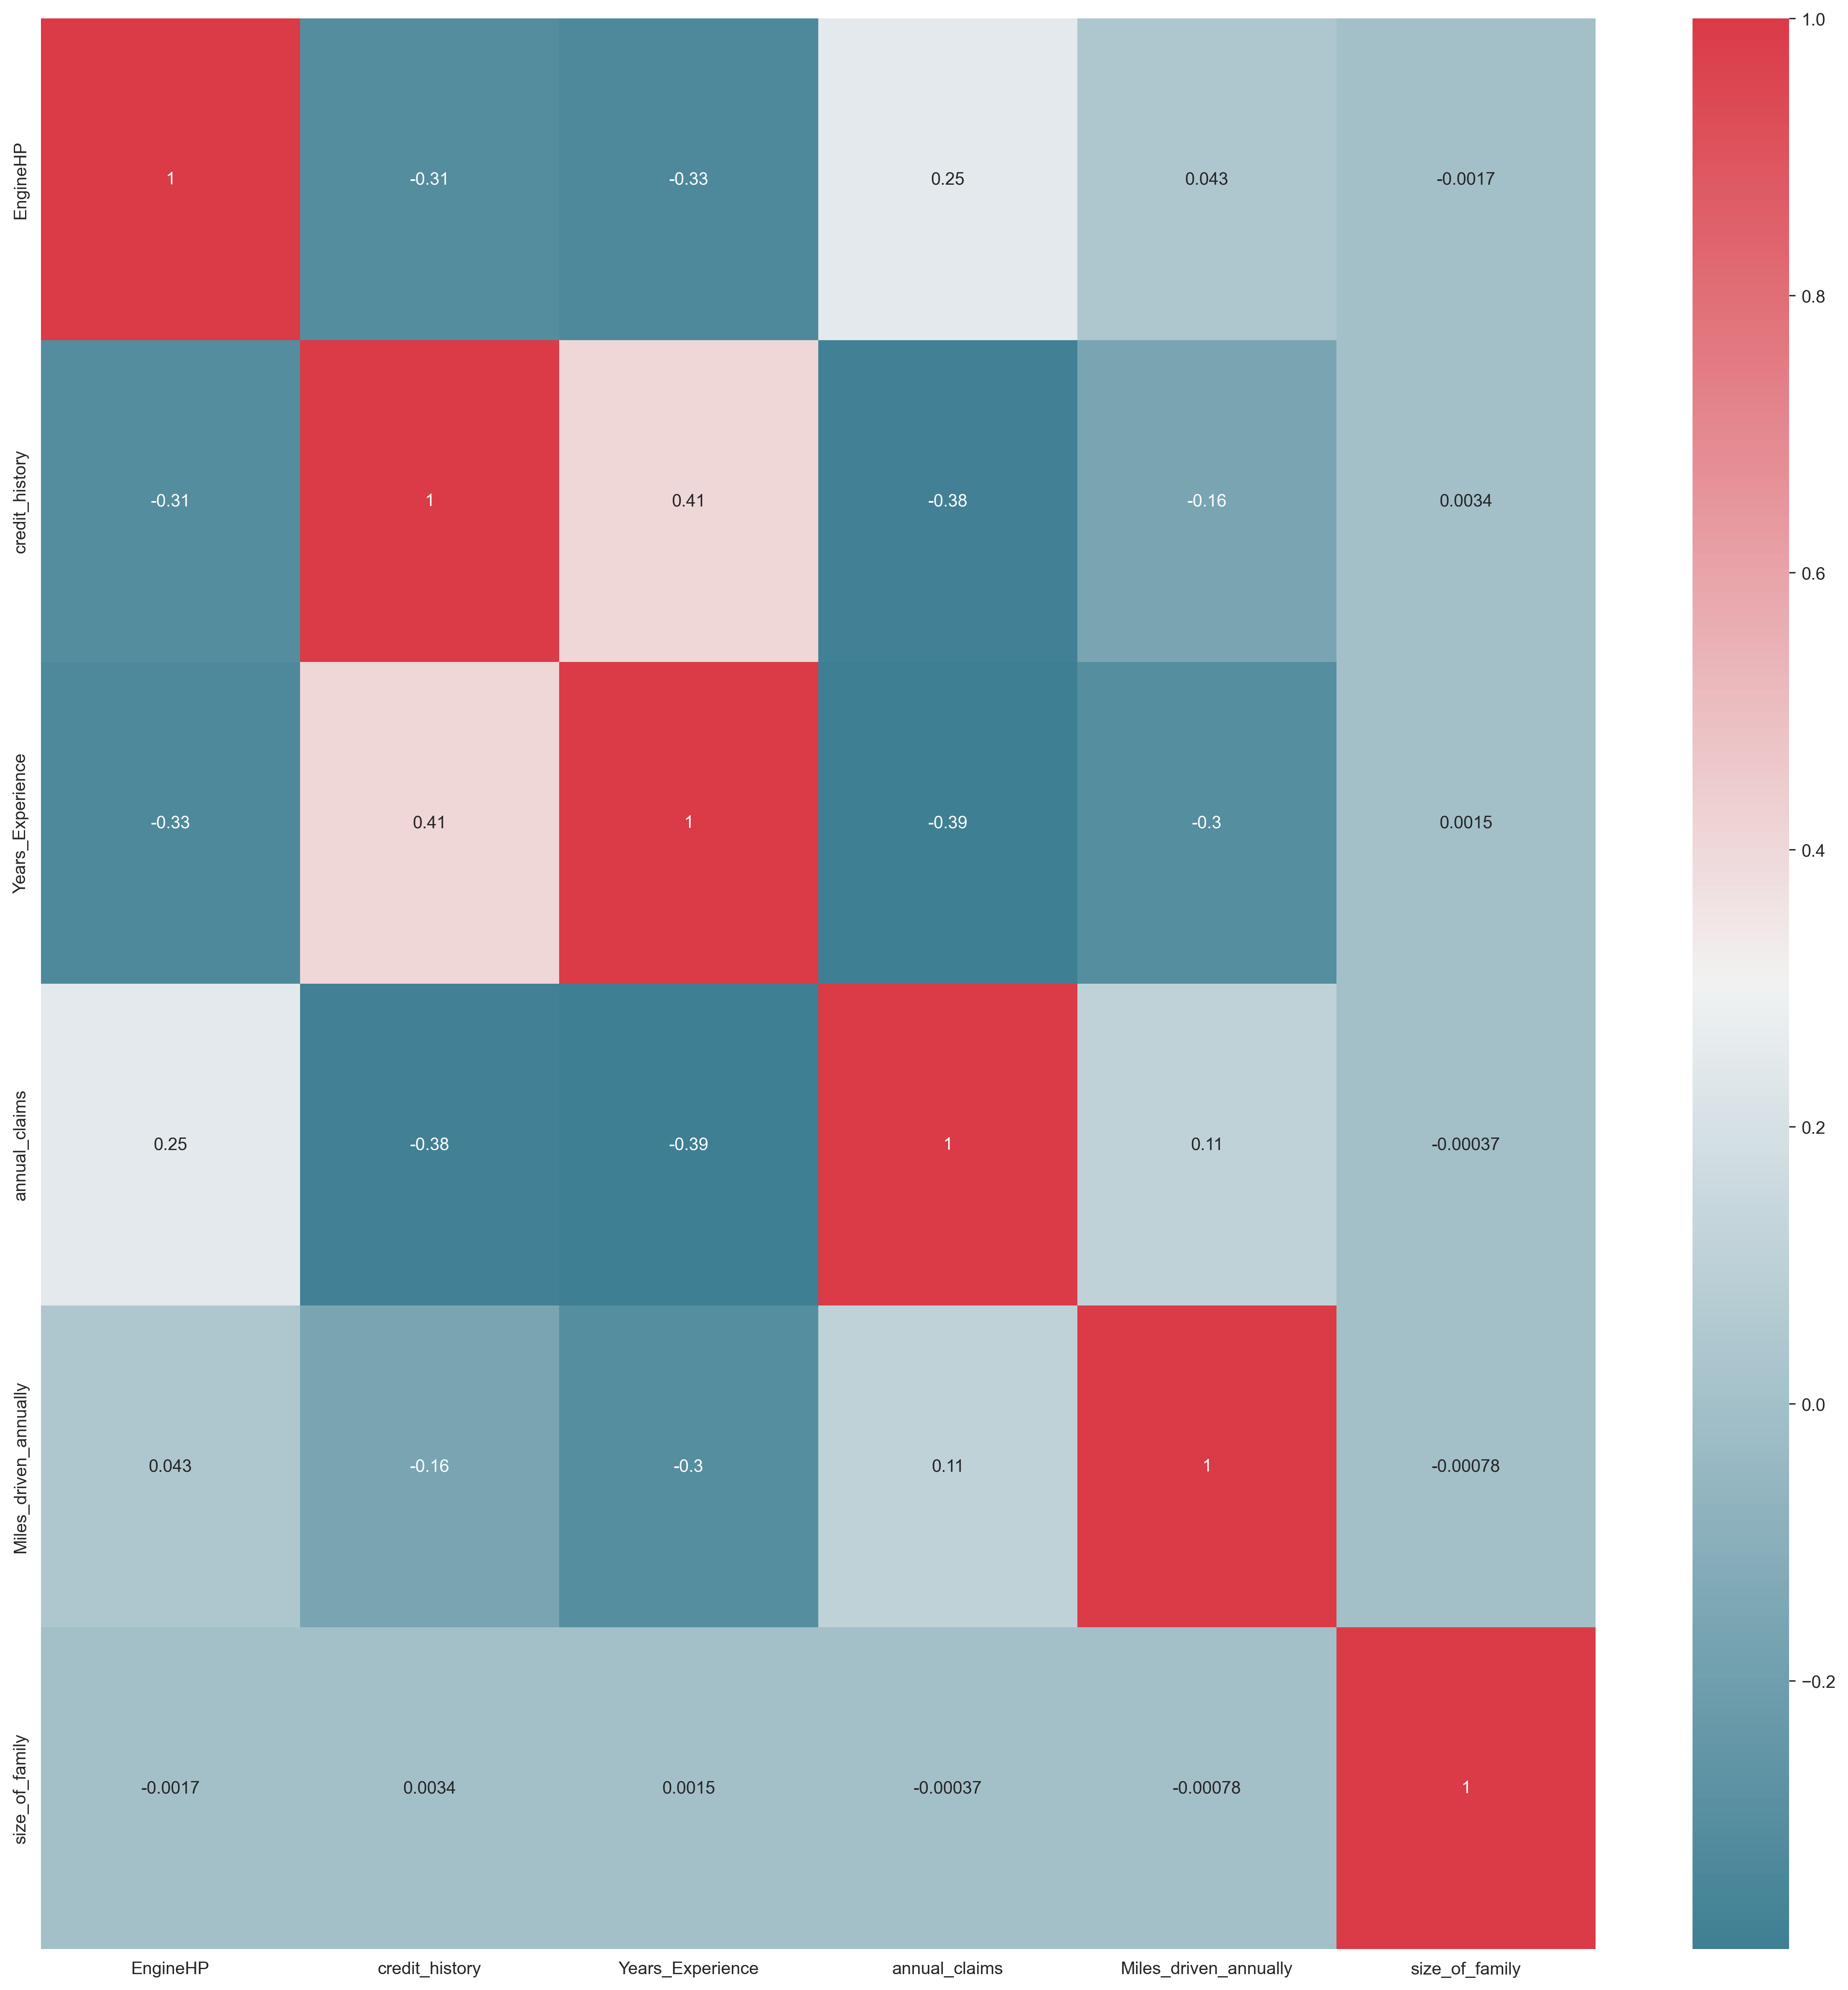

In [26]:
sns.set_style("white")
color_map = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(20, 20))
sns.heatmap(safe_driver_num_features.corr(), annot=True, cmap=color_map)
plt.show()



The features are not highly correlated with our target variable. We can keep the remaining features as  it is.

In [27]:
safe_driver_num_features = pd.concat(
    [safe_driver_num_features, safe_driver["target"]],axis=1)

In [28]:
safe_driver_num_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30240 entries, 0 to 30239
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   EngineHP               30240 non-null  int64  
 1   credit_history         30240 non-null  int64  
 2   Years_Experience       30240 non-null  int64  
 3   annual_claims          30240 non-null  int64  
 4   Miles_driven_annually  30240 non-null  float64
 5   size_of_family         30240 non-null  int64  
 6   target                 30240 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 1.6 MB


##  Outlier Detection and Handling 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181440 entries, 0 to 181439
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   target    181440 non-null  int64  
 1   variable  181440 non-null  object 
 2   value     181440 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.2+ MB


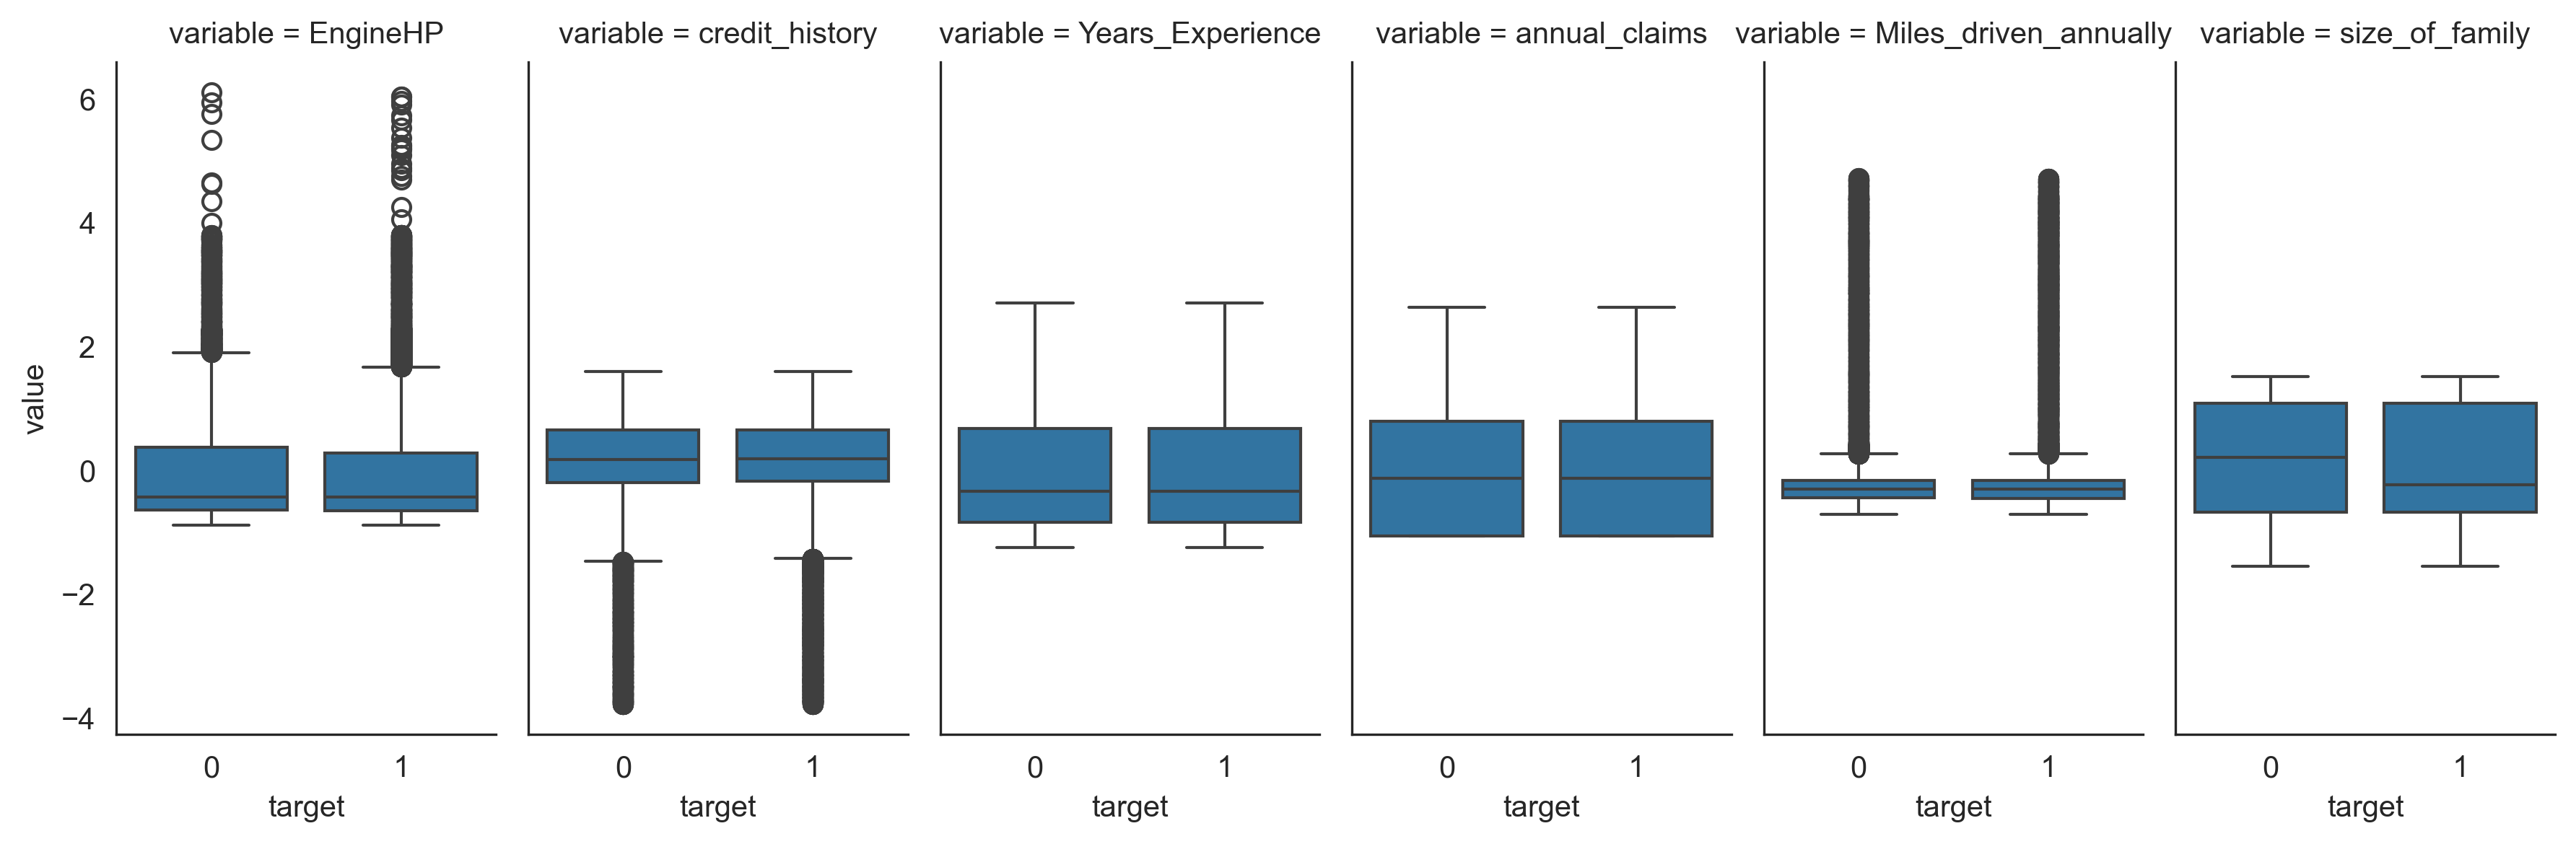

In [29]:
# Let us also look at the relationship between our dependent variable with categorical variables
# Plot all the variables with boxplots for each continuous variable.
# Restructure the data so we can use FaceGrid

safe_driver_melt = pd.melt(safe_driver_scaled, id_vars=["target"])
safe_driver_melt.info()
g = sns.FacetGrid(safe_driver_melt, col="variable", height=4, aspect=.5)
g = g.map(sns.boxplot, "target", "value")

plt.show()

Our boxplots indicate that there are some outliers in EngineHP, credit_history and Miles_driven_annually. 

**Using the Interquartile Range (IQR)**

Outliers in numerical features like EngineHP, credit_history, and Miles_driven_annually are identified and removed using the IQR (Interquartile Range) method.

In [30]:
import pandas as pd
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.50)
    Q3 = data.quantile(0.60)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data < lower_bound) | (data > upper_bound)]

outliers_engine_hp = detect_outliers_iqr(safe_driver['EngineHP'])
outliers_credit_history = detect_outliers_iqr(safe_driver['credit_history'])
outliers_miles_driven = detect_outliers_iqr(safe_driver['Miles_driven_annually'])


In [31]:
# Remove outliers using the IQR method
safe_driver_cleaned = safe_driver[~((safe_driver['EngineHP'].isin(outliers_engine_hp)) |
                  (safe_driver['credit_history'].isin(outliers_credit_history)) |
                  (safe_driver['Miles_driven_annually'].isin(outliers_miles_driven)))]


In [32]:

safe_driver['EngineHP'] = pd.to_numeric(safe_driver['EngineHP'], errors='coerce')
safe_driver['credit_history'] = pd.to_numeric(safe_driver['credit_history'], errors='coerce')
safe_driver['Miles_driven_annually'] = pd.to_numeric(safe_driver['Miles_driven_annually'], errors='coerce')


In [33]:
# Dropping NaN values
safe_driver = safe_driver.dropna(subset=['EngineHP', 'credit_history', 'Miles_driven_annually'])

# Alternatively, fill NaN values
# df['EngineHP'].fillna(df['EngineHP'].median(), inplace=True)
# df['credit_history'].fillna(df['credit_history'].median(), inplace=True)
# df['Miles_driven_annually'].fillna(df['Miles_driven_annually'].median(), inplace=True)


**Before cleaning** 

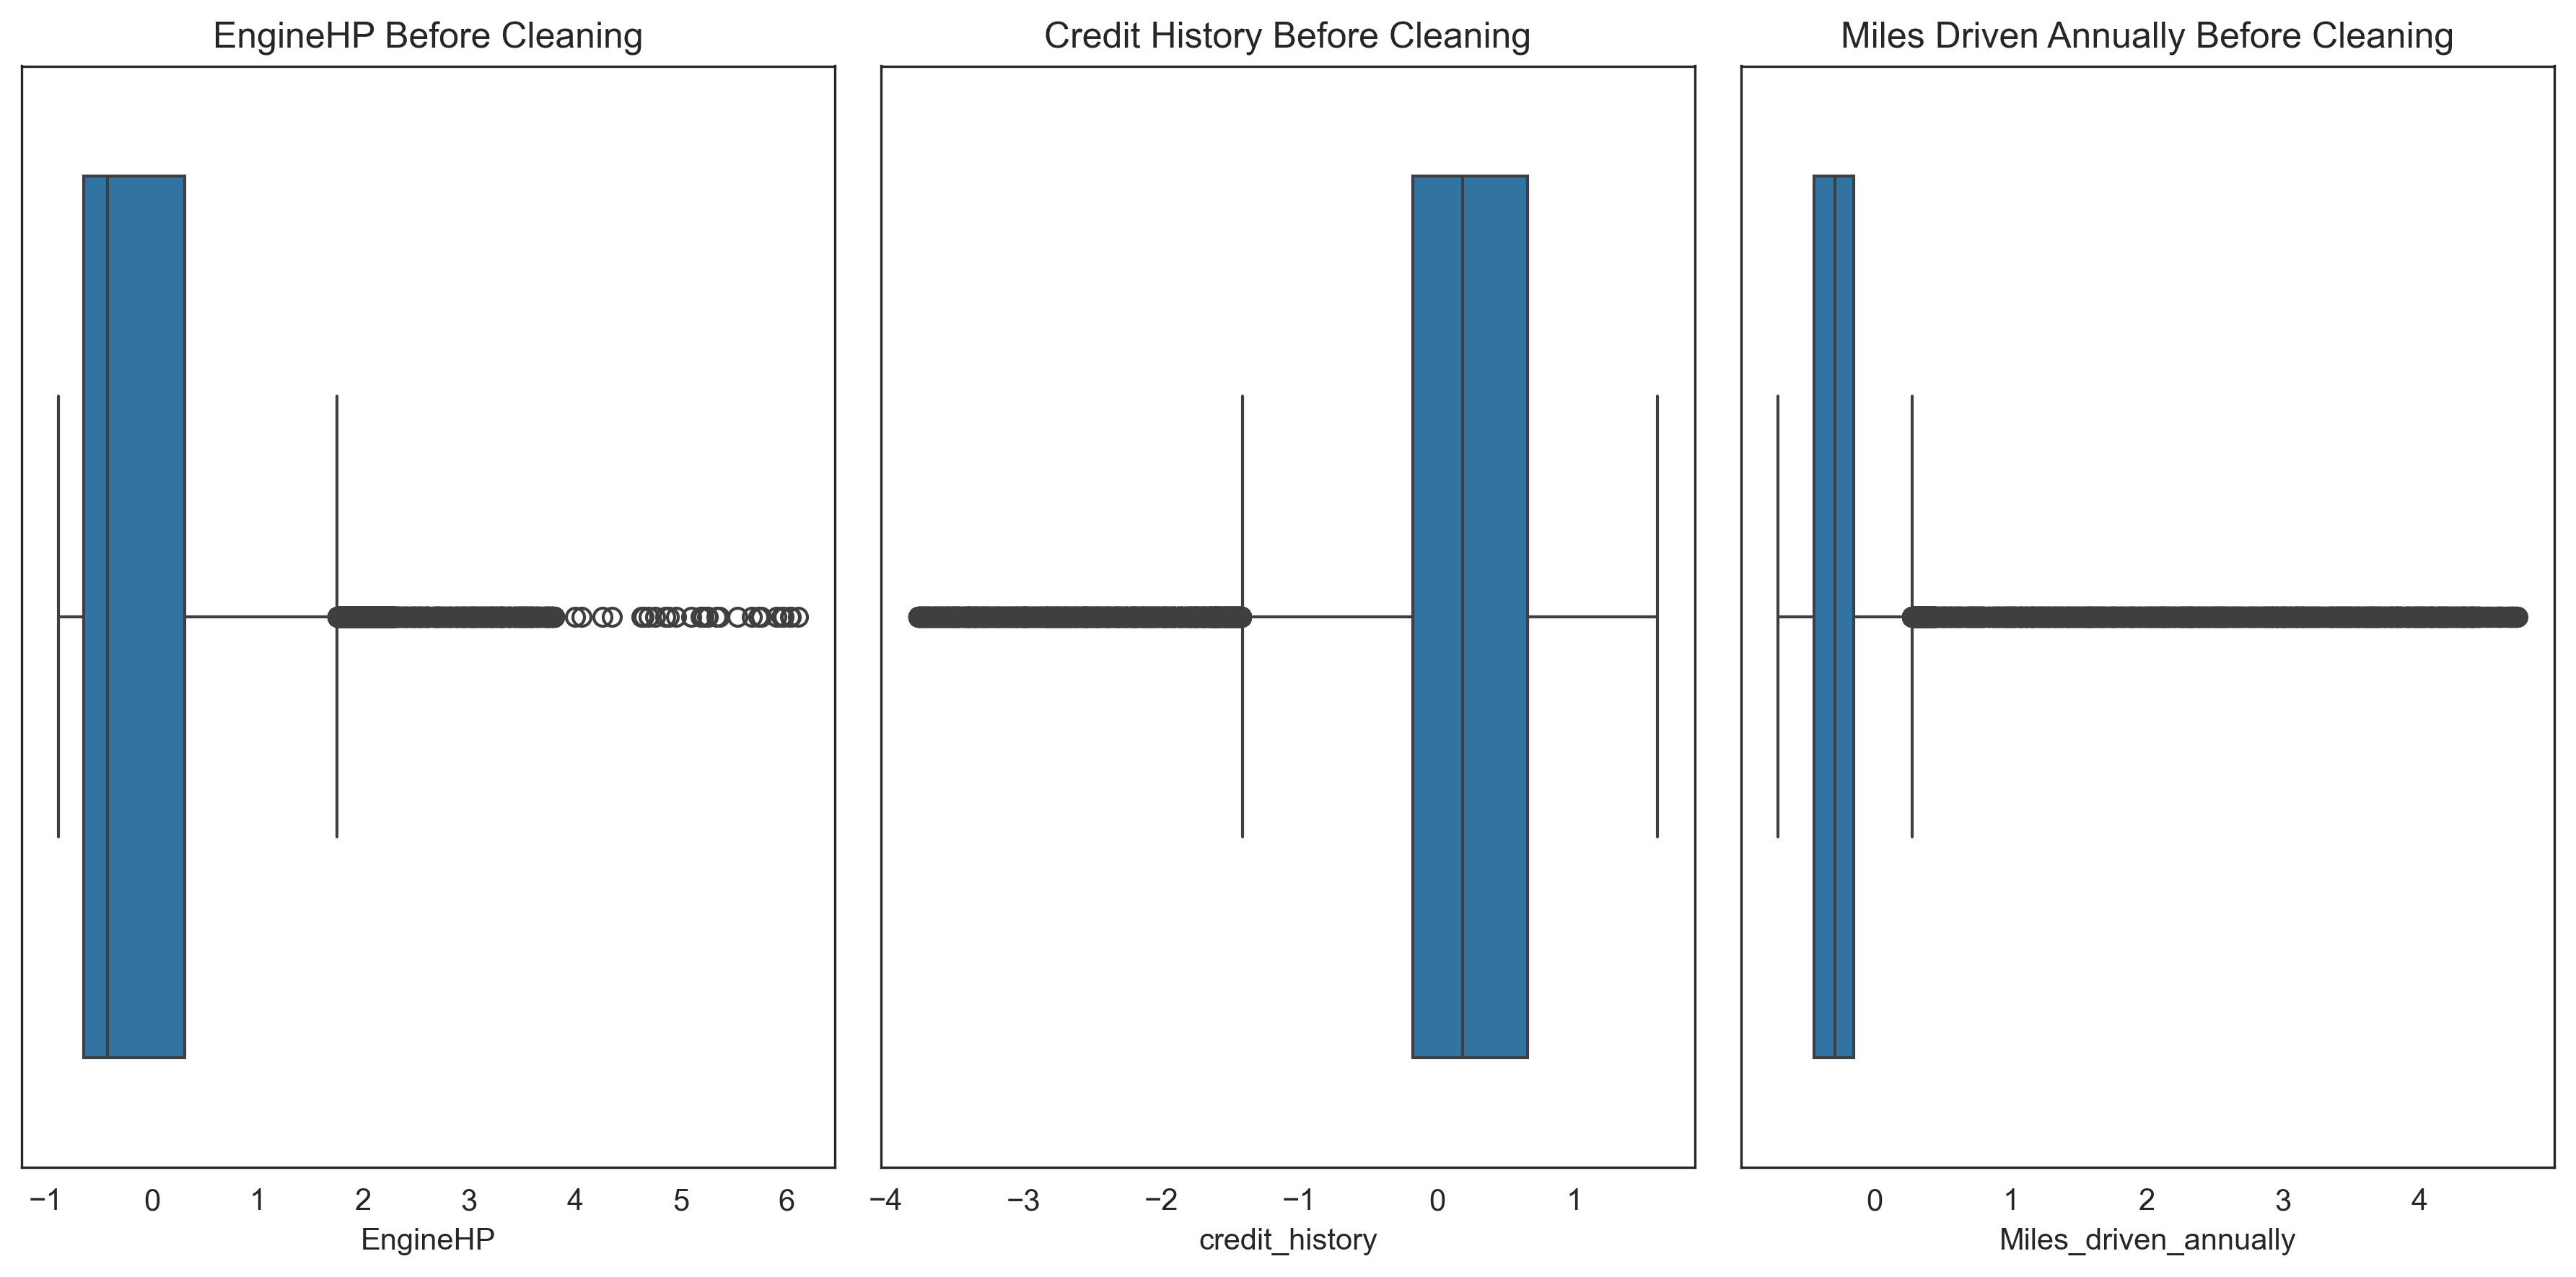

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.boxplot(x=safe_driver['EngineHP'])
plt.title('EngineHP Before Cleaning')

plt.subplot(1, 3, 2)
sns.boxplot(x=safe_driver['credit_history'])
plt.title('Credit History Before Cleaning')

plt.subplot(1, 3, 3)
sns.boxplot(x=safe_driver['Miles_driven_annually'])
plt.title('Miles Driven Annually Before Cleaning')

plt.tight_layout()
plt.show()


**After cleaning**

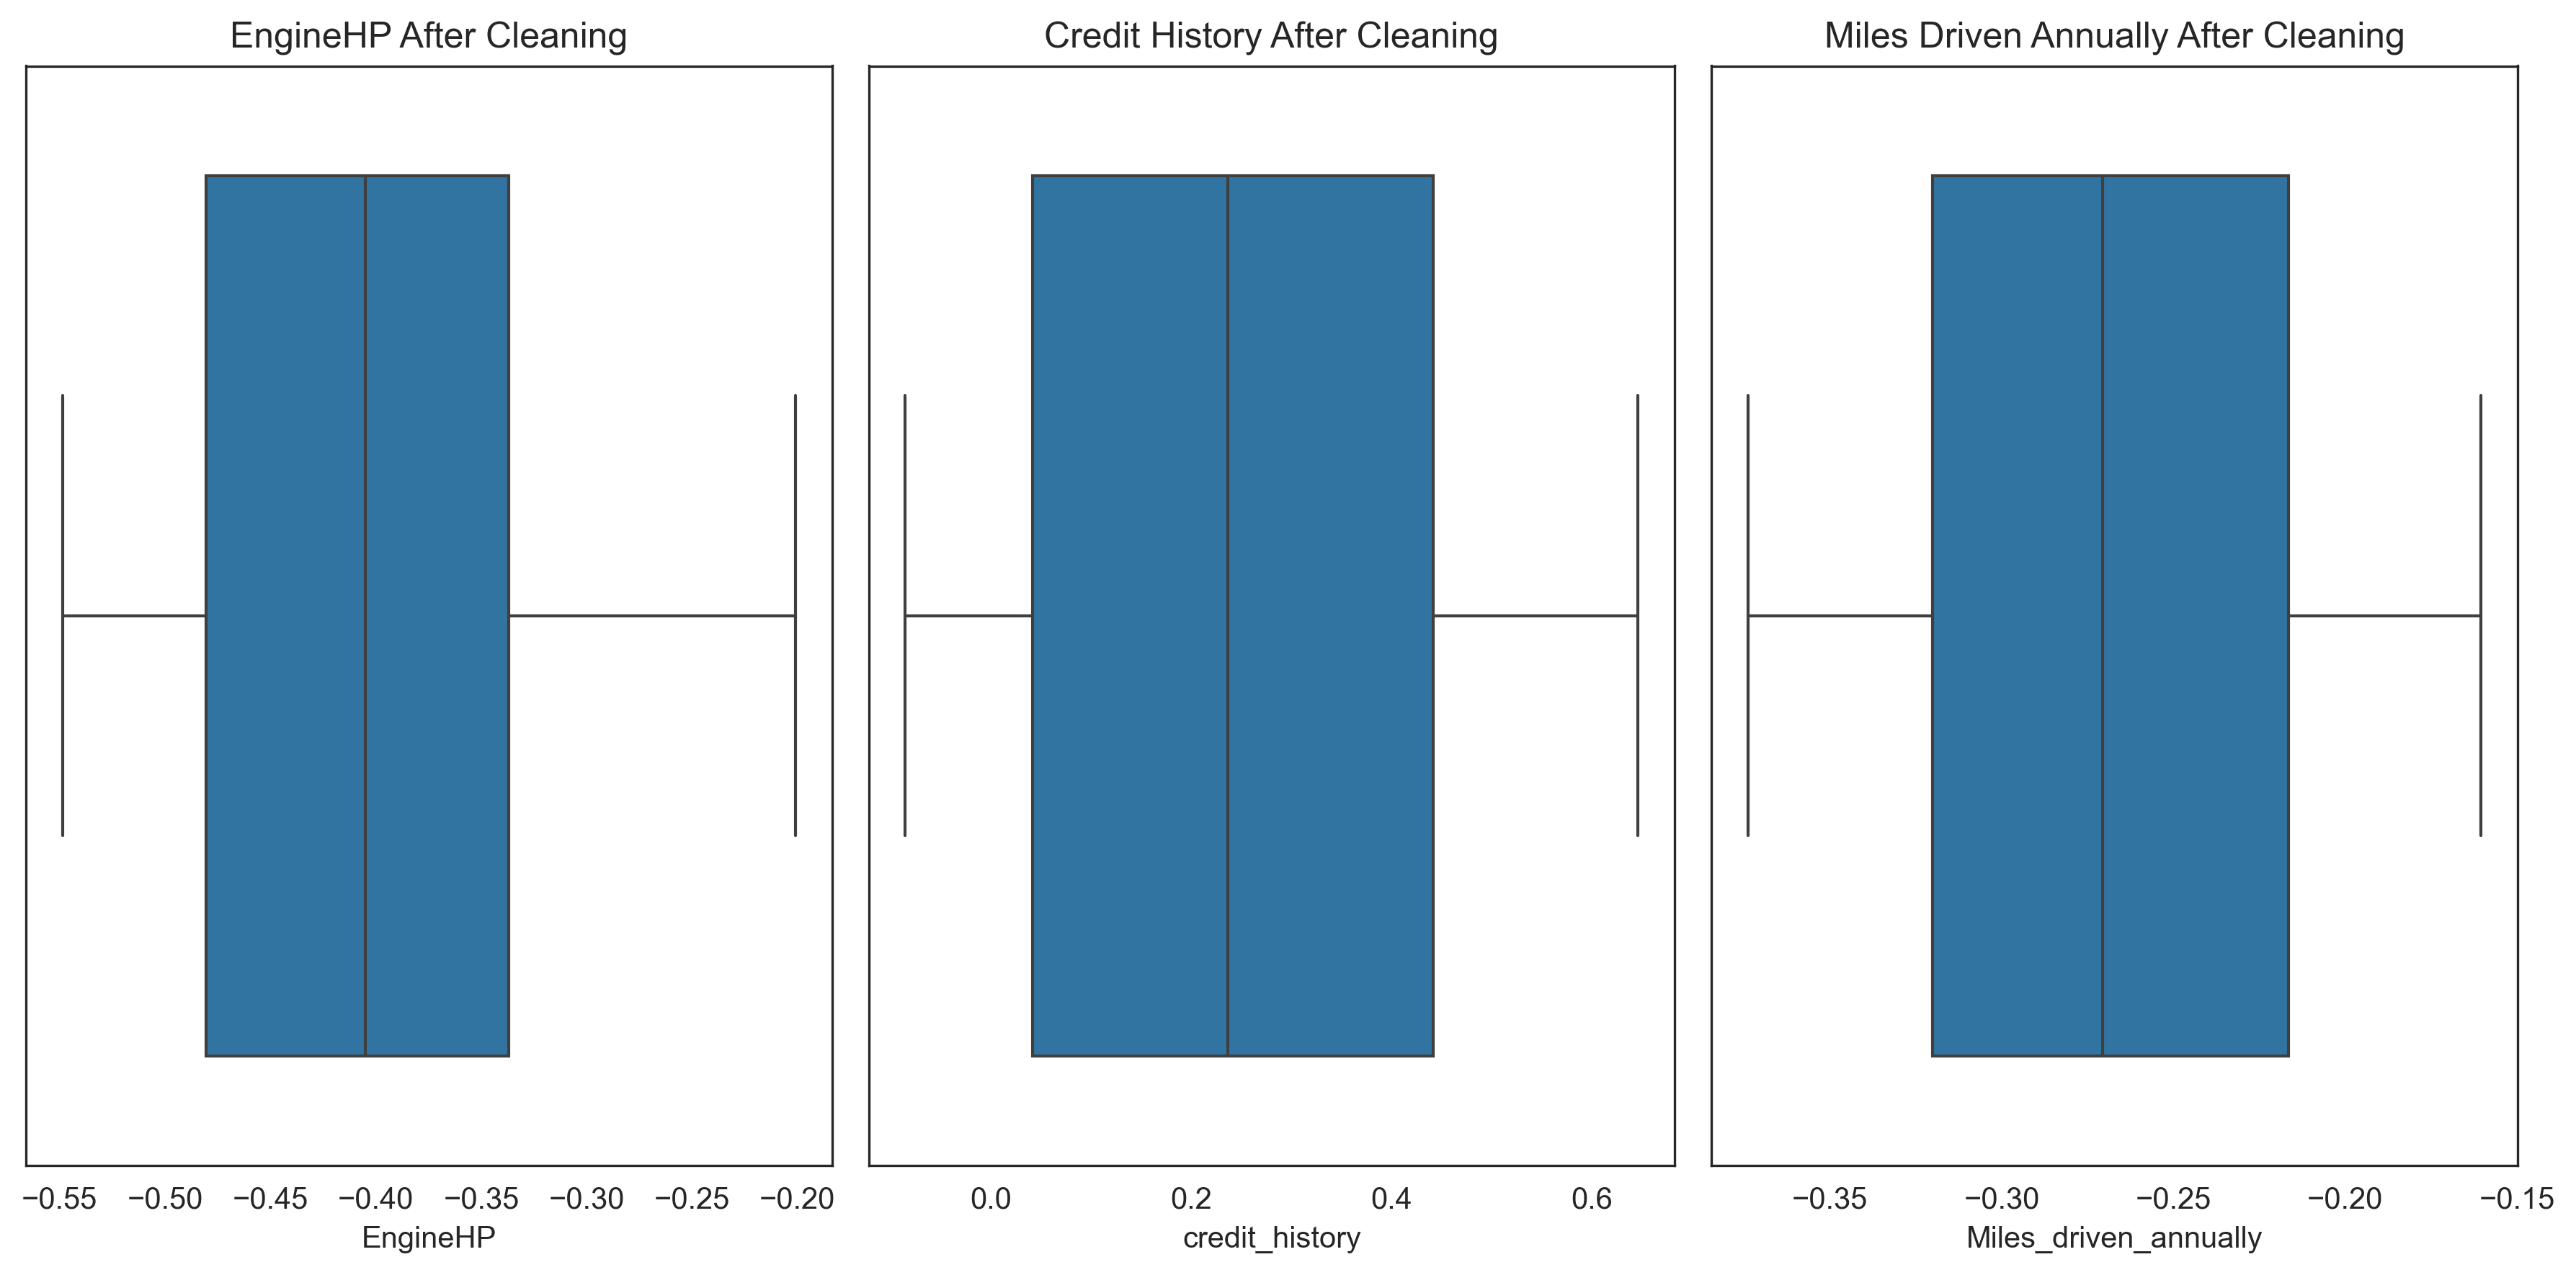

In [35]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.boxplot(x=safe_driver_cleaned['EngineHP'])
plt.title('EngineHP After Cleaning')

plt.subplot(1, 3, 2)
sns.boxplot(x=safe_driver_cleaned['credit_history'])
plt.title('Credit History After Cleaning')

plt.subplot(1, 3, 3)
sns.boxplot(x=safe_driver_cleaned['Miles_driven_annually'])
plt.title('Miles Driven Annually After Cleaning')

plt.tight_layout()
plt.show()

Here below we separate our fature set from the label target and convert all the categorical variables to numeric. Then split the feature set into training and test data sets.


## **Data Transformation** 


#### **Label Encoding for Categorical Variables**

Let us convert some of the categorical features into numerical giving weightage to each variable.
1. Gender: 1 = Female and 2 = Male
2. Marital_Status: 1 = Single and 2 = Married
3. Vehicle_Type: Use LabelEncoder
4. Age_bucket: Use LabelEncoder

We are not using 'dummies' or 'OneHotEncoder' because these create sparse materices and increase dimensionality. By giving a 1 or a 2 for say Marital_Status we give higher weightage to 'Married' by assiging a value of 2.

In [36]:
safe_driver.head(10)

,EngineHP,credit_history,Years_Experience,annual_claims,Miles_driven_annually,size_of_family,target,Gender,Marital_Status,Vehical_type,Age_bucket,State
0,2.459,-0.291,-1.239,-1.051,-0.153,0.209,1,F,Married,Car,<18,IL
1,3.736,0.178,0.277,-1.051,-0.116,0.647,1,F,Married,Car,28-34,NJ
2,-0.481,0.051,0.176,-1.051,-0.427,-0.665,1,M,Married,Van,>40,CT
3,-0.382,0.334,-0.430,-1.051,3.427,-0.665,1,M,Married,Van,18-27,CT
4,-0.518,0.832,1.996,-0.128,-0.185,-0.228,1,M,Married,Van,>40,WY
5,-0.397,0.354,0.480,-0.128,-0.298,1.521,1,F,Married,Truck,>40,DE
6,-0.345,0.998,1.794,1.719,-0.198,-1.103,1,F,Married,Truck,>40,NJ
7,-0.821,0.598,0.783,-0.128,-0.184,0.209,1,F,Single,Car,>40,ME
8,3.449,0.305,2.097,-1.051,-0.019,-1.540,1,F,Married,Car,>40,CA
9,-0.579,0.969,0.581,-0.128,-0.648,-1.540,0,F,Married,Truck,35-40,NJ


In [37]:
# Convert Gender to a 1 or a 2 
safe_driver["Gender"] = np.where(safe_driver["Gender"] == "F", 1, 2)

# Convert Marital_Status to 1 or 2
safe_driver["Marital_Status"] = np.where(
    safe_driver["Marital_Status"] == "Single", 1, 2)

# Convert Vehical_type using LabelEncoder
le = preprocessing.LabelEncoder()
le.fit(safe_driver["Vehical_type"])
safe_driver["Vehical_type"] = le.transform(safe_driver["Vehical_type"])

# Convert Age_bucket using LabelEncoder
le.fit(safe_driver["Age_bucket"])
safe_driver["Age_bucket"] = le.transform(safe_driver["Age_bucket"])

In [38]:
safe_driver.head(10)

,EngineHP,credit_history,Years_Experience,annual_claims,Miles_driven_annually,size_of_family,target,Gender,Marital_Status,Vehical_type,Age_bucket,State
0,2.459,-0.291,-1.239,-1.051,-0.153,0.209,1,1,2,0,3,IL
1,3.736,0.178,0.277,-1.051,-0.116,0.647,1,1,2,0,1,NJ
2,-0.481,0.051,0.176,-1.051,-0.427,-0.665,1,2,2,3,4,CT
3,-0.382,0.334,-0.430,-1.051,3.427,-0.665,1,2,2,3,0,CT
4,-0.518,0.832,1.996,-0.128,-0.185,-0.228,1,2,2,3,4,WY
5,-0.397,0.354,0.480,-0.128,-0.298,1.521,1,1,2,1,4,DE
6,-0.345,0.998,1.794,1.719,-0.198,-1.103,1,1,2,1,4,NJ
7,-0.821,0.598,0.783,-0.128,-0.184,0.209,1,1,1,0,4,ME
8,3.449,0.305,2.097,-1.051,-0.019,-1.540,1,1,2,0,4,CA
9,-0.579,0.969,0.581,-0.128,-0.648,-1.540,0,1,2,1,2,NJ


## **Data Preparation**

In [39]:
# Drop the 'target' column from training dataframe as that is our label
x = safe_driver.drop(['target', 'State'], axis=1)  

#The 'target' column is our label or outcome that we want to predict 
y = safe_driver['target']

# Use pd.dummies to resolve the categorical data into numerical values
# X = pd.get_dummies(X)

# Drop and NaN values
x = x.dropna(axis=1)  

We found out much earlier that our target label is 70% failure (unsafe driver or target == 1) and 30% success(safe driver or target == 0). 

## **MODELLING**

### **Synthetic Minority Over-sampling Technique (SMOTE)**

Let us do class balancing using SMOTE and see the distribution.   

In [40]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)

# Apply SMOTE
os_data_x, os_data_y = os.fit_resample(x, y)  # Using Y
os_data_y = pd.Series(os_data_y)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    os_data_x, os_data_y, test_size=0.3, random_state=0)

# Print statistics about the oversampled data
print("Length of oversampled data is ", len(os_data_x))
print("Number of Negative class in oversampled data ",
      len(os_data_y[os_data_y == 0]))  # Updated to directly check Series
print("Number of Positive class in oversampled data ",
      len(os_data_y[os_data_y == 1]))  # Updated to directly check Series
print("Proportion of Negative class in oversampled data is ",
      len(os_data_y[os_data_y == 0]) / len(os_data_x))
print("Proportion of Positive class in oversampled data is ",
      len(os_data_y[os_data_y == 1]) / len(os_data_x))

Length of oversampled data is  42792
Number of Negative class in oversampled data  21396
Number of Positive class in oversampled data  21396
Proportion of Negative class in oversampled data is  0.5
Proportion of Positive class in oversampled data is  0.5


### **Feature Importance**

Let us find out how significant are our features are in predicting our label. we will use the feature_importances_method from the RandomForestClassifier. After that we plot the relative importance of the features using a barplot.

Let us go ahead and select our categorical features, using a RandomForestClassifier.

## **Random Forest**

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=12)
regr.fit(x, y)
feature_importances = pd.DataFrame(regr.feature_importances_, index=x.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                       importance
credit_history              0.378
Miles_driven_annually       0.329
EngineHP                    0.203
Years_Experience            0.059
Gender                      0.031
annual_claims               0.000
size_of_family              0.000
Marital_Status              0.000
Vehical_type                0.000
Age_bucket                  0.000


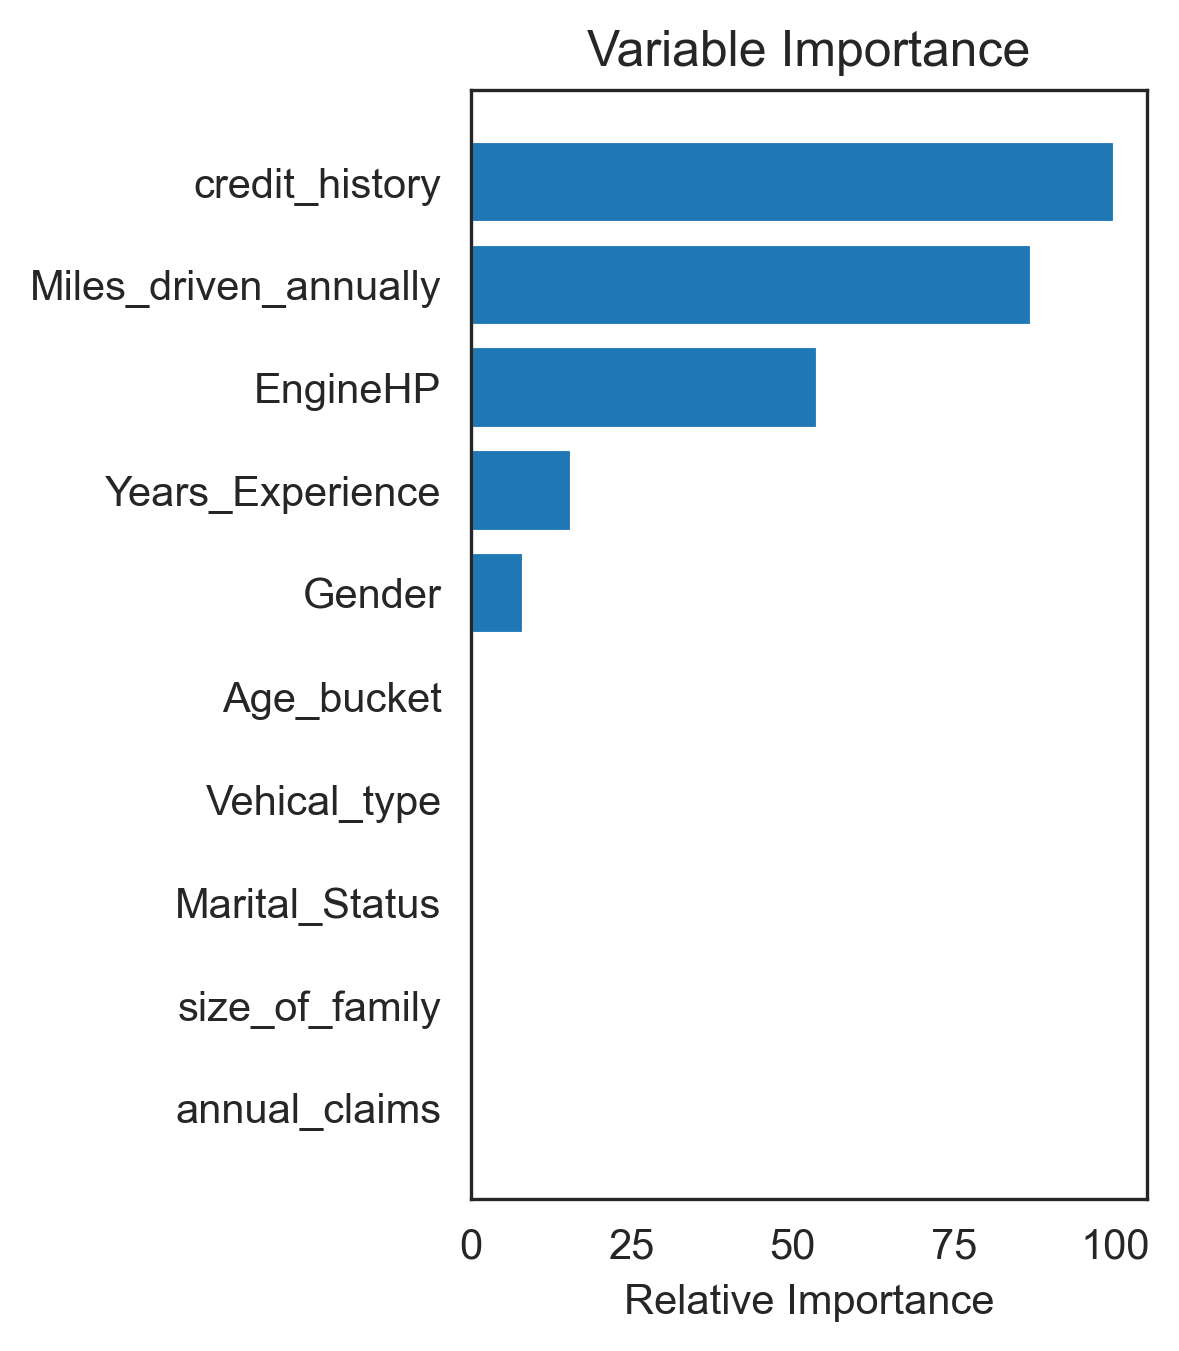

In [42]:
feature_importance = regr.feature_importances_
feature_importance = 100.0 * (feature_importance/feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.subplot(1,2,2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## **Decision Tree**

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)

y_predict = tree.predict(x_test)
test_score = tree.score(x_test, y_test)

dt_train_scores = cross_val_score(estimator=tree, X=x_train, y=y_train, cv=5, n_jobs=4)
dt_test_scores = cross_val_score(estimator=tree, X=x_test, y=y_test, cv=5, n_jobs=4)

In [44]:
print(dt_train_scores)
print(dt_test_scores)

[0.65698548 0.66917042 0.6581539  0.66249374 0.65442404]
[0.6152648  0.62227414 0.61214953 0.62797039 0.60342813]


In [45]:
target_names = ['Safe Driver', 'Unsafe Driver']
decision_tree = classification_report(
    y_test, y_predict, target_names= target_names, output_dict=True)

In [46]:
confusion_matrix(y_test, y_predict)

array([[4386, 2032],
       [2257, 4163]], dtype=int64)

In [47]:
model = DecisionTreeClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Decision Tree Accuracy: %.2f%%" % (accuracy * 100.0))


Decision Tree Accuracy: 66.69%


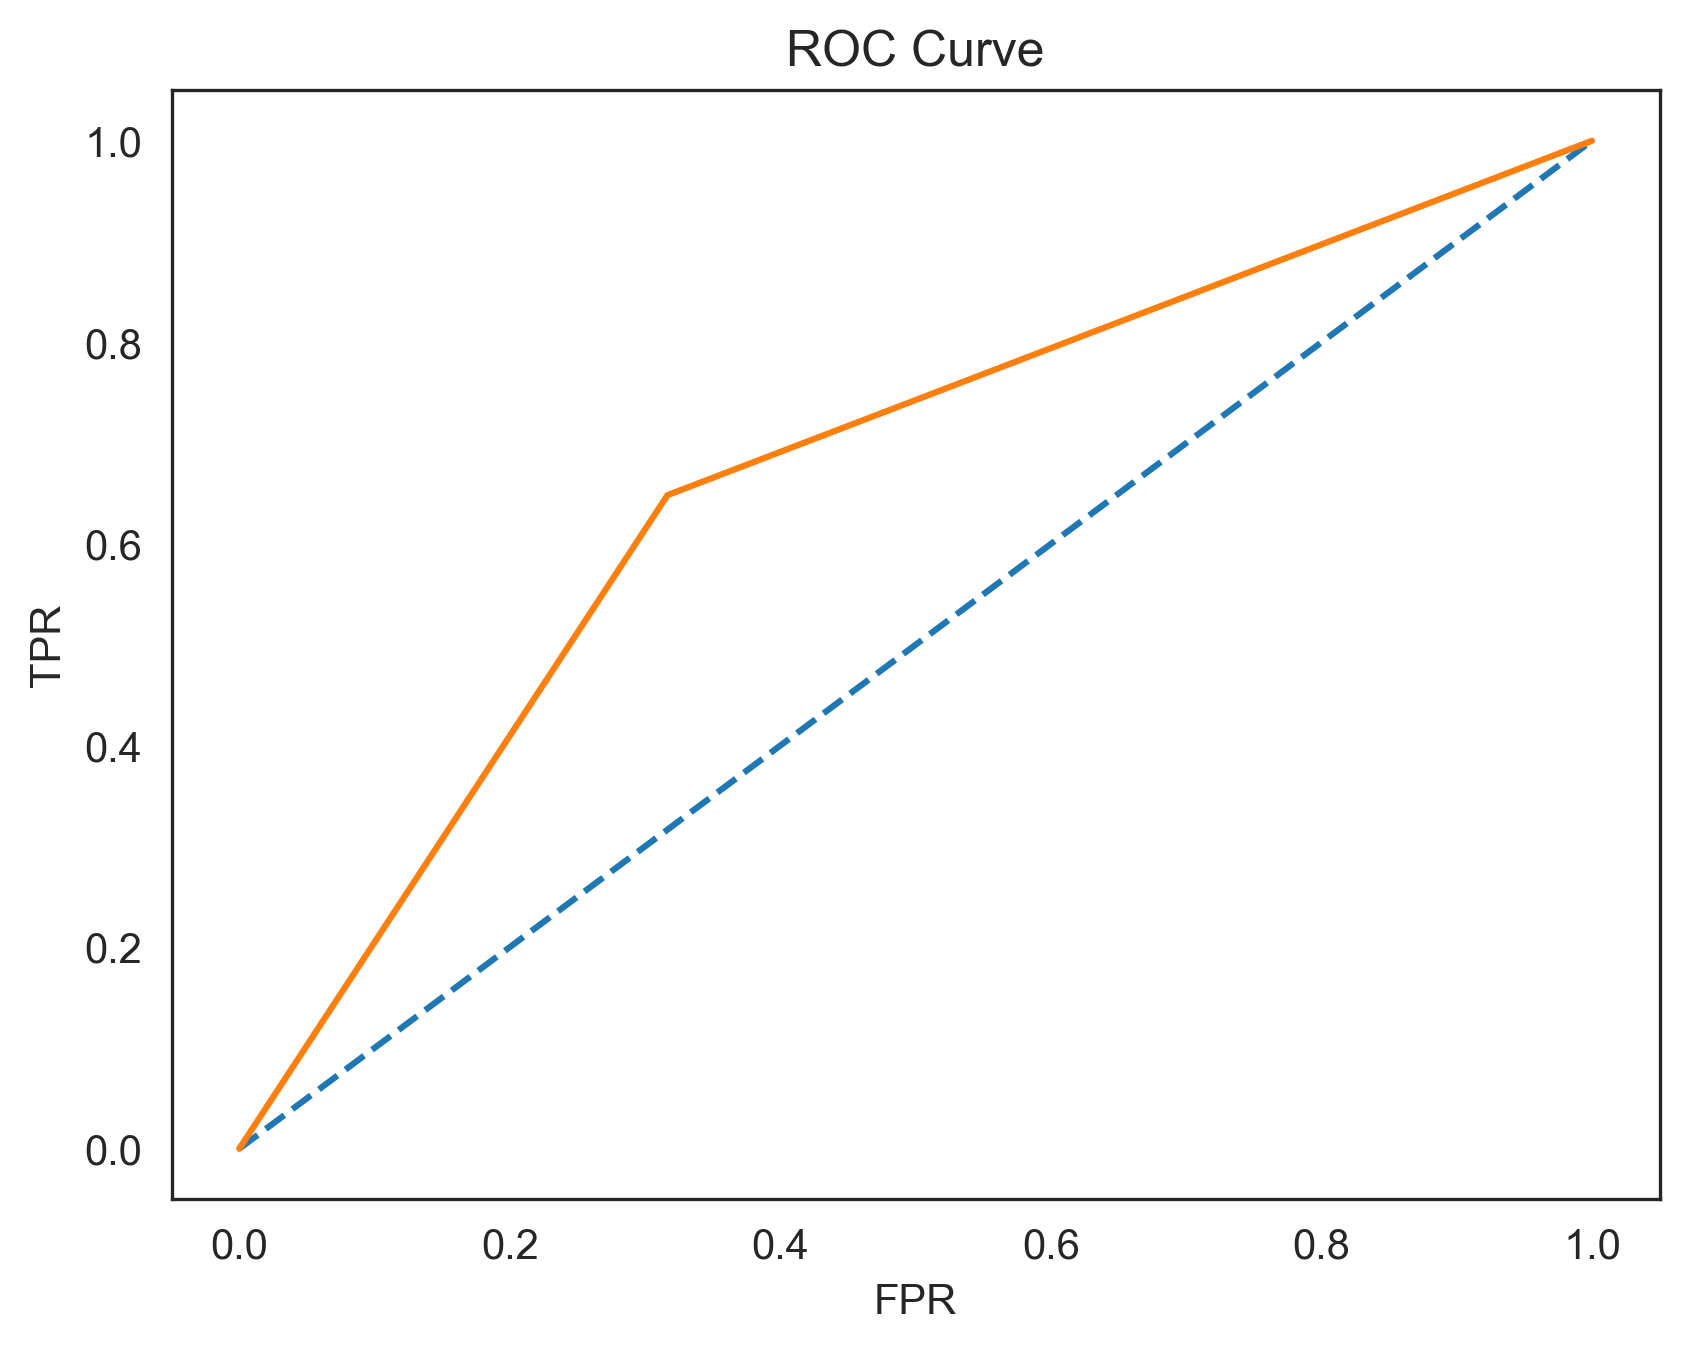

0.6659164159601743


In [48]:
probs = tree.predict_proba(x_test)
probs = probs[:, 1]

# Calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.plot([0,1], [0,1], linestyle='--')

#Plot the roc curve for the model
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

plt.show()
auc = roc_auc_score(y_test, probs)
print(auc)

Our confusion matrix based  on the Decision Tree does not look good . it is showing a high number of false positives and false negatives


## **Support Vector**

In [49]:
#Run Support vector classifier to verify accuracy
from sklearn.svm import SVC

In [50]:
svc = SVC(gamma='auto', probability=True)

In [51]:
svc.fit(x_train, y_train)

SVC(gamma='auto', probability=True)

In [52]:
y_predict = svc.predict(x_test)
svc.score(x_test, y_test)

0.5341174637794049

In [53]:
svc_train_scores = cross_val_score(svc, X=x_train, y=y_train, cv=5)

In [54]:
svc_test_scores = cross_val_score(svc, X=x_test, y=y_test, cv=5)

In [55]:
print(svc_train_scores)
print(svc_test_scores)

[0.51760975 0.5259556  0.5181105  0.52462026 0.52804674]
[0.52920561 0.52531153 0.52920561 0.52512661 0.51071289]


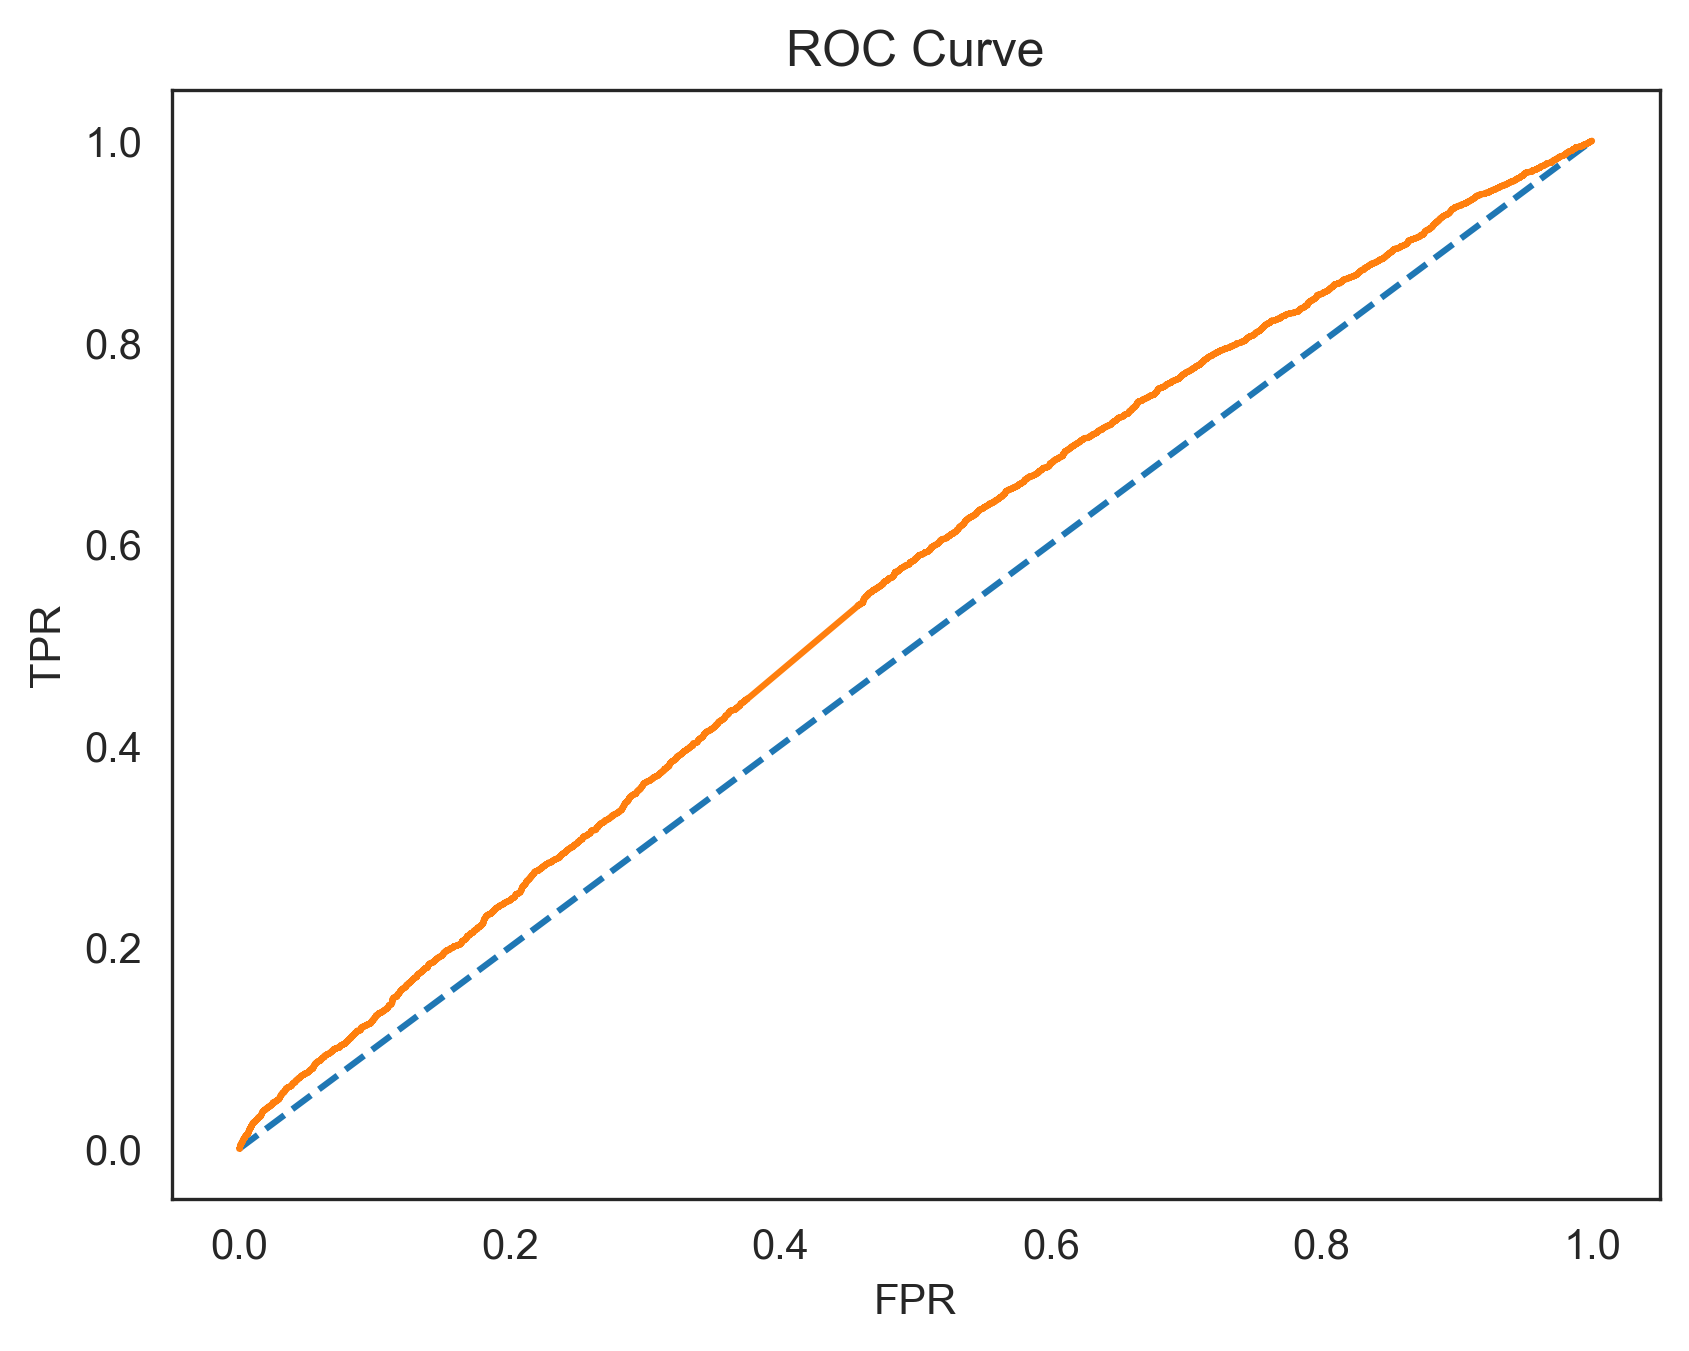

0.5539301579766409


In [56]:
probs = svc.predict_proba(x_test)
probs = probs[:, 1]

# Calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.plot([0,1], [0,1], linestyle='--')

# Plot the roc curve for the model
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')


plt.show()
auc = roc_auc_score(y_test, probs)
print(auc)

In [57]:
target_names = ['Safe Driver', 'Unsafe Driver']
svc_scores = classification_report(
    y_test, y_predict, target_names= target_names, output_dict=True)

In [58]:
confusion_matrix(y_test, y_predict)

array([[4125, 2293],
       [3688, 2732]], dtype=int64)

In [59]:
model = SVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("SVC Accuracy: %.2f%%" % (accuracy * 100.0))


SVC Accuracy: 52.42%


The SVM Classifier returns less than better results than the Decision Tree model

## **Stochastic Gradient Descent** 

In [60]:
from sklearn import linear_model
clf = linear_model.SGDClassifier(max_iter=10000, tol=1e-3)
clf.fit(x_train, y_train)
y_predict_SGD = clf.predict(x_train)
clf.score(x_train, y_train)

0.5010683047339254

In [61]:
sgd_train_score = cross_val_score(clf, x_train, y_train, cv=5)

In [62]:
sgd_test_score = cross_val_score(clf, x_test, y_test, cv=5)

In [63]:
print(sgd_train_score)
print(sgd_test_score)

[0.49323986 0.50108496 0.49607745 0.50776164 0.50383973]
[0.50817757 0.48948598 0.50389408 0.51382937 0.50447994]


In [64]:
target_names = ['Safe Driver', 'Unsafe Driver']
sgd_scores = classification_report(
    y_test, y_predict, target_names= target_names, output_dict=True)

In [65]:
confusion_matrix(y_train, y_predict_SGD)

array([[5086, 9892],
       [5053, 9923]], dtype=int64)

In [66]:

model = linear_model.SGDClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("SGD Classifier Accuracy: %.2f%%" % (accuracy * 100.0))


SGD Classifier Accuracy: 50.43%


## **Support Vector with different tuning parameters**

Trying SVC again with better tuning parameters found out from StackOverFlow.

In [67]:
from sklearn.svm import SVC

# Define the classifier with various hyperparameters
classifier = SVC(C=10, cache_size=200, class_weight="balanced", coef0=0.0,
                 decision_function_shape="ovr", degree=3, gamma="auto", kernel="rbf", max_iter=-1,
                 probability=False, random_state=None, shrinking=True, tol=0.001, verbose=False)

classifier = classifier.fit(x_train, y_train)
y_predict = classifier.predict(x_train)

In [68]:
svc_2_train_score = cross_val_score(classifier, x_train, y_train, cv=5)

In [69]:
svc_2_test_score = cross_val_score(classifier, x_test, y_test, cv=5)

In [70]:
print(svc_2_train_score)
print(svc_2_test_score)

[0.52712402 0.53930896 0.53747288 0.54431647 0.54440735]
[0.53621495 0.52686916 0.53777259 0.54226724 0.52824309]


In [71]:
target_names = ['Safe Driver', 'Unsafe Driver']
svc_2_scores = classification_report(
    y_train, y_predict, target_names= target_names, output_dict=True)

In [72]:
confusion_matrix(y_train, y_predict)

array([[10364,  4614],
       [ 7542,  7434]], dtype=int64)

In [73]:
model = SVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("SVC 2 Accuracy: %.2f%%" % (accuracy * 100.0))

SVC 2 Accuracy: 52.42%


## **Ridge**

In [74]:
from sklearn.linear_model import RidgeClassifier
clf = RidgeClassifier().fit(x_train, y_train)
clf.score(x_train, y_train)
y_predict = classifier.predict(x_train)

In [75]:
ridge_train_score = cross_val_score(clf, x_train, y_train, cv=5)

In [76]:
ridge_test_score = cross_val_score(clf, x_test, y_test, cv=5)

In [77]:
print(ridge_train_score)
print(ridge_test_score)

[0.49924887 0.50208646 0.49090302 0.5092639  0.50601002]
[0.51752336 0.50661994 0.51168224 0.5029217  0.49668874]


In [78]:
target_names = ['Safe Driver', 'Unsafe Driver']
ridge_scores = classification_report(
    y_train, y_predict, target_names= target_names, output_dict=True)

In [79]:
model = RidgeClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Ridge Accuracy: %.2f%%" % (accuracy * 100.0))

Ridge Accuracy: 50.37%


## **Gradient Boosting**

In [80]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(loss = "deviance", max_depth=10)
clf_model = clf.fit(x_train, y_train)
print(clf_model)
print("Training set score:", clf.score(x_train, y_train))

GradientBoostingClassifier(loss='deviance', max_depth=10)
Training set score: 0.8953395205982506


In [81]:
from sklearn.model_selection import cross_val_score
GB_train_score = cross_val_score(clf, x_train, y_train, cv=5)
print('\nEach Cross Validated Accuracy: \n', GB_train_score)
print("\nOverall Gradient Boosted Classifier Accuracy: %0.2f (+/- %0.2f)\n" % 
      (GB_train_score.mean(), GB_train_score.std() * 2))



Each Cross Validated Accuracy: 
 [0.74561843 0.74795527 0.7541312  0.74595226 0.74724541]

Overall Gradient Boosted Classifier Accuracy: 0.75 (+/- 0.01)



In [82]:
GB_test_score = cross_val_score(clf, x_test, y_test, cv=5)

In [83]:
print(GB_train_score)
print(GB_test_score)

[0.74561843 0.74795527 0.7541312  0.74595226 0.74724541]
[0.7161215  0.73325545 0.71495327 0.73237242 0.72458122]


In [84]:
y_predict = clf.predict(x_train)
target_names = ['Safe Driver', 'Unsafe Driver']
GB_scores = classification_report(
    y_train, y_predict, target_names= target_names, output_dict=True)
confusion_matrix(y_train, y_predict)

array([[11911,  3067],
       [   68, 14908]], dtype=int64)

In [86]:
model = GradientBoostingClassifier()

# Train the model
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Gradient Boosting Accuracy: %.2f%%" % (accuracy * 100.0))


Gradient Boosting Accuracy: 69.83%


Gradient Boosting seems to be experiencing overfitting?

We will try XGBoost model which is supposed to be the 'Quee of All' or 'GB on Steroids'.

## **XGB Model**

In [87]:
XGB_scores = classification_report(y_train, y_predict, target_names=target_names, output_dict= True)

In [88]:
XGB_train_score = cross_val_score(model, x_train, y_train, cv=5)

In [89]:
XGB_test_score = cross_val_score(model, x_test, y_test, cv=5)

In [90]:
print(XGB_train_score)
print(XGB_test_score)

[0.69404106 0.69337339 0.69938241 0.69804707 0.71268781]
[0.6873053  0.68146417 0.69898754 0.70666147 0.7015972 ]


In [91]:
model = XGBClassifier()
model.fit(x_train, y_train)

# Make predictions for test data
y_pred = model.predict(x_test)
y_predict = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, y_predict)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 71.48%


## **Visualization** 

### **Model Comparison (Precision and Recall)**

### **For Safe Driver**

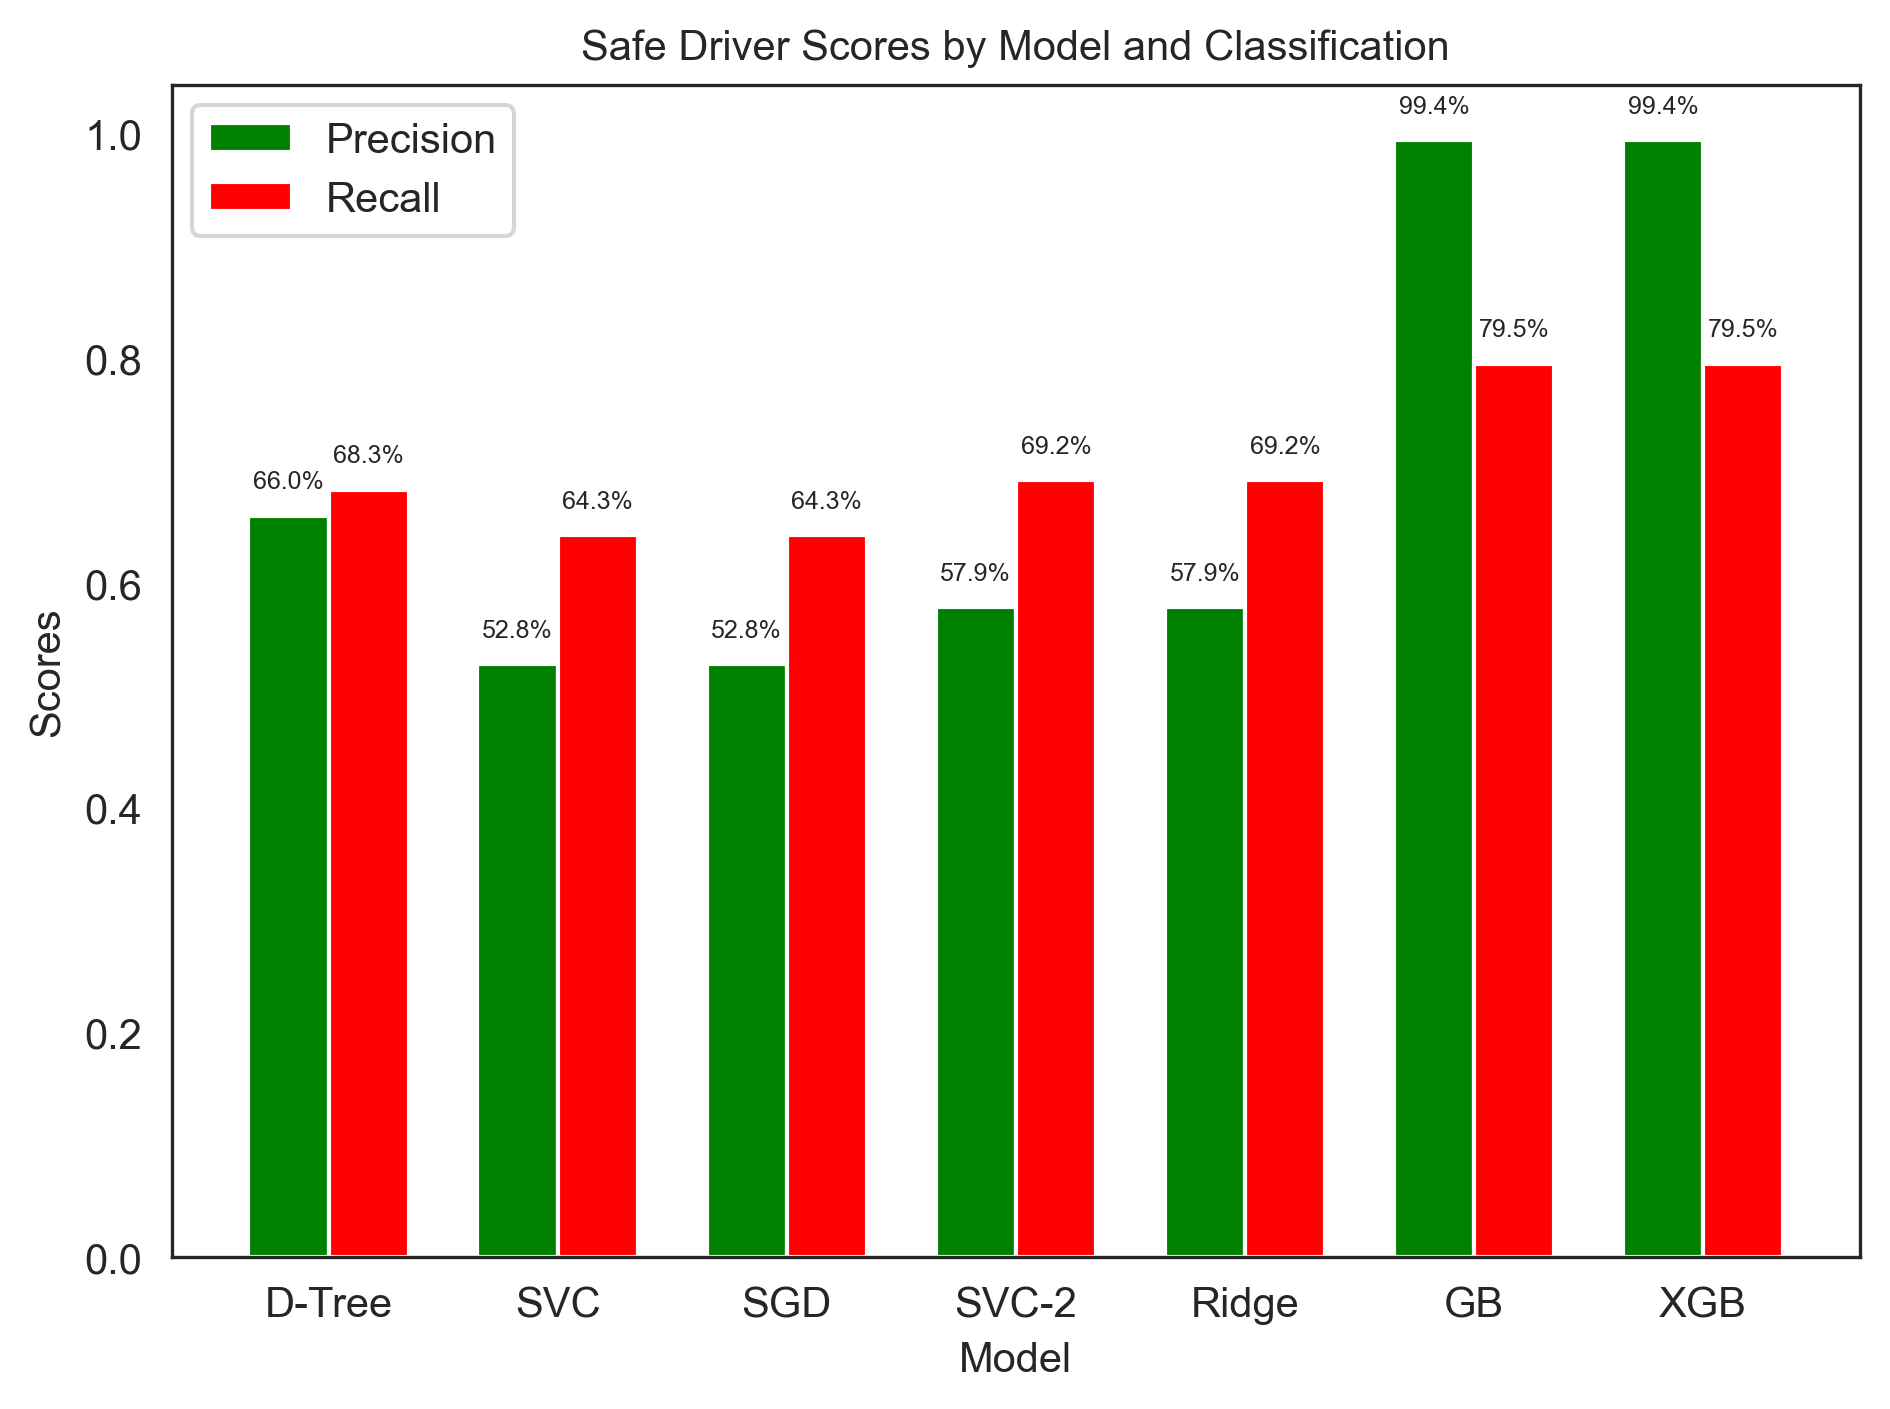

In [96]:
# Collect all the Classification Scores and plot results as a bargraph to compare performances of different models

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 300

n_groups = 7

# Sample data (Replace these with your actual data)
precision = (decision_tree["Safe Driver"]["precision"],
             svc_scores["Safe Driver"]["precision"],
             sgd_scores["Safe Driver"]["precision"],
             svc_2_scores["Safe Driver"]["precision"],
             ridge_scores["Safe Driver"]["precision"],
             GB_scores["Safe Driver"]["precision"],
             XGB_scores["Safe Driver"]["precision"])

recall = (decision_tree["Safe Driver"]["recall"],
          svc_scores["Safe Driver"]["recall"],
          sgd_scores["Safe Driver"]["recall"],
          svc_2_scores["Safe Driver"]["recall"],
          ridge_scores["Safe Driver"]["recall"],
          GB_scores["Safe Driver"]["recall"],
          XGB_scores["Safe Driver"]["recall"])

# Create the figure and axis
fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {"ecolor": "0.3"}

# Create bars for precision and recall
rects1 = ax.bar(index, precision, bar_width, color='g', error_kw=error_config, label="Precision")
rects2 = ax.bar(index + bar_width, recall, bar_width, color='r', error_kw=error_config, label="Recall")

# Add percentage labels on top of each bar
for rect in rects1:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height*100:.1f}%', ha='center', va='bottom', fontsize=6)

for rect in rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height*100:.1f}%', ha='center', va='bottom', fontsize=6)

# Set labels, title and ticks
ax.set_xlabel("Model", fontsize=10)
ax.set_ylabel("Scores", fontsize=10)
ax.set_title("Safe Driver Scores by Model and Classification", fontsize=10)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(("D-Tree", "SVC", "SGD", "SVC-2", "Ridge", "GB", "XGB"), fontsize=10)

# Add a legend
ax.legend()

# Layout adjustment and saving
fig.tight_layout()
plt.savefig("Safe_Driver_Bargraph_with_Percentage_200.png", dpi=200, transparent=True)


plt.show()


### **For Unsafe Driver**

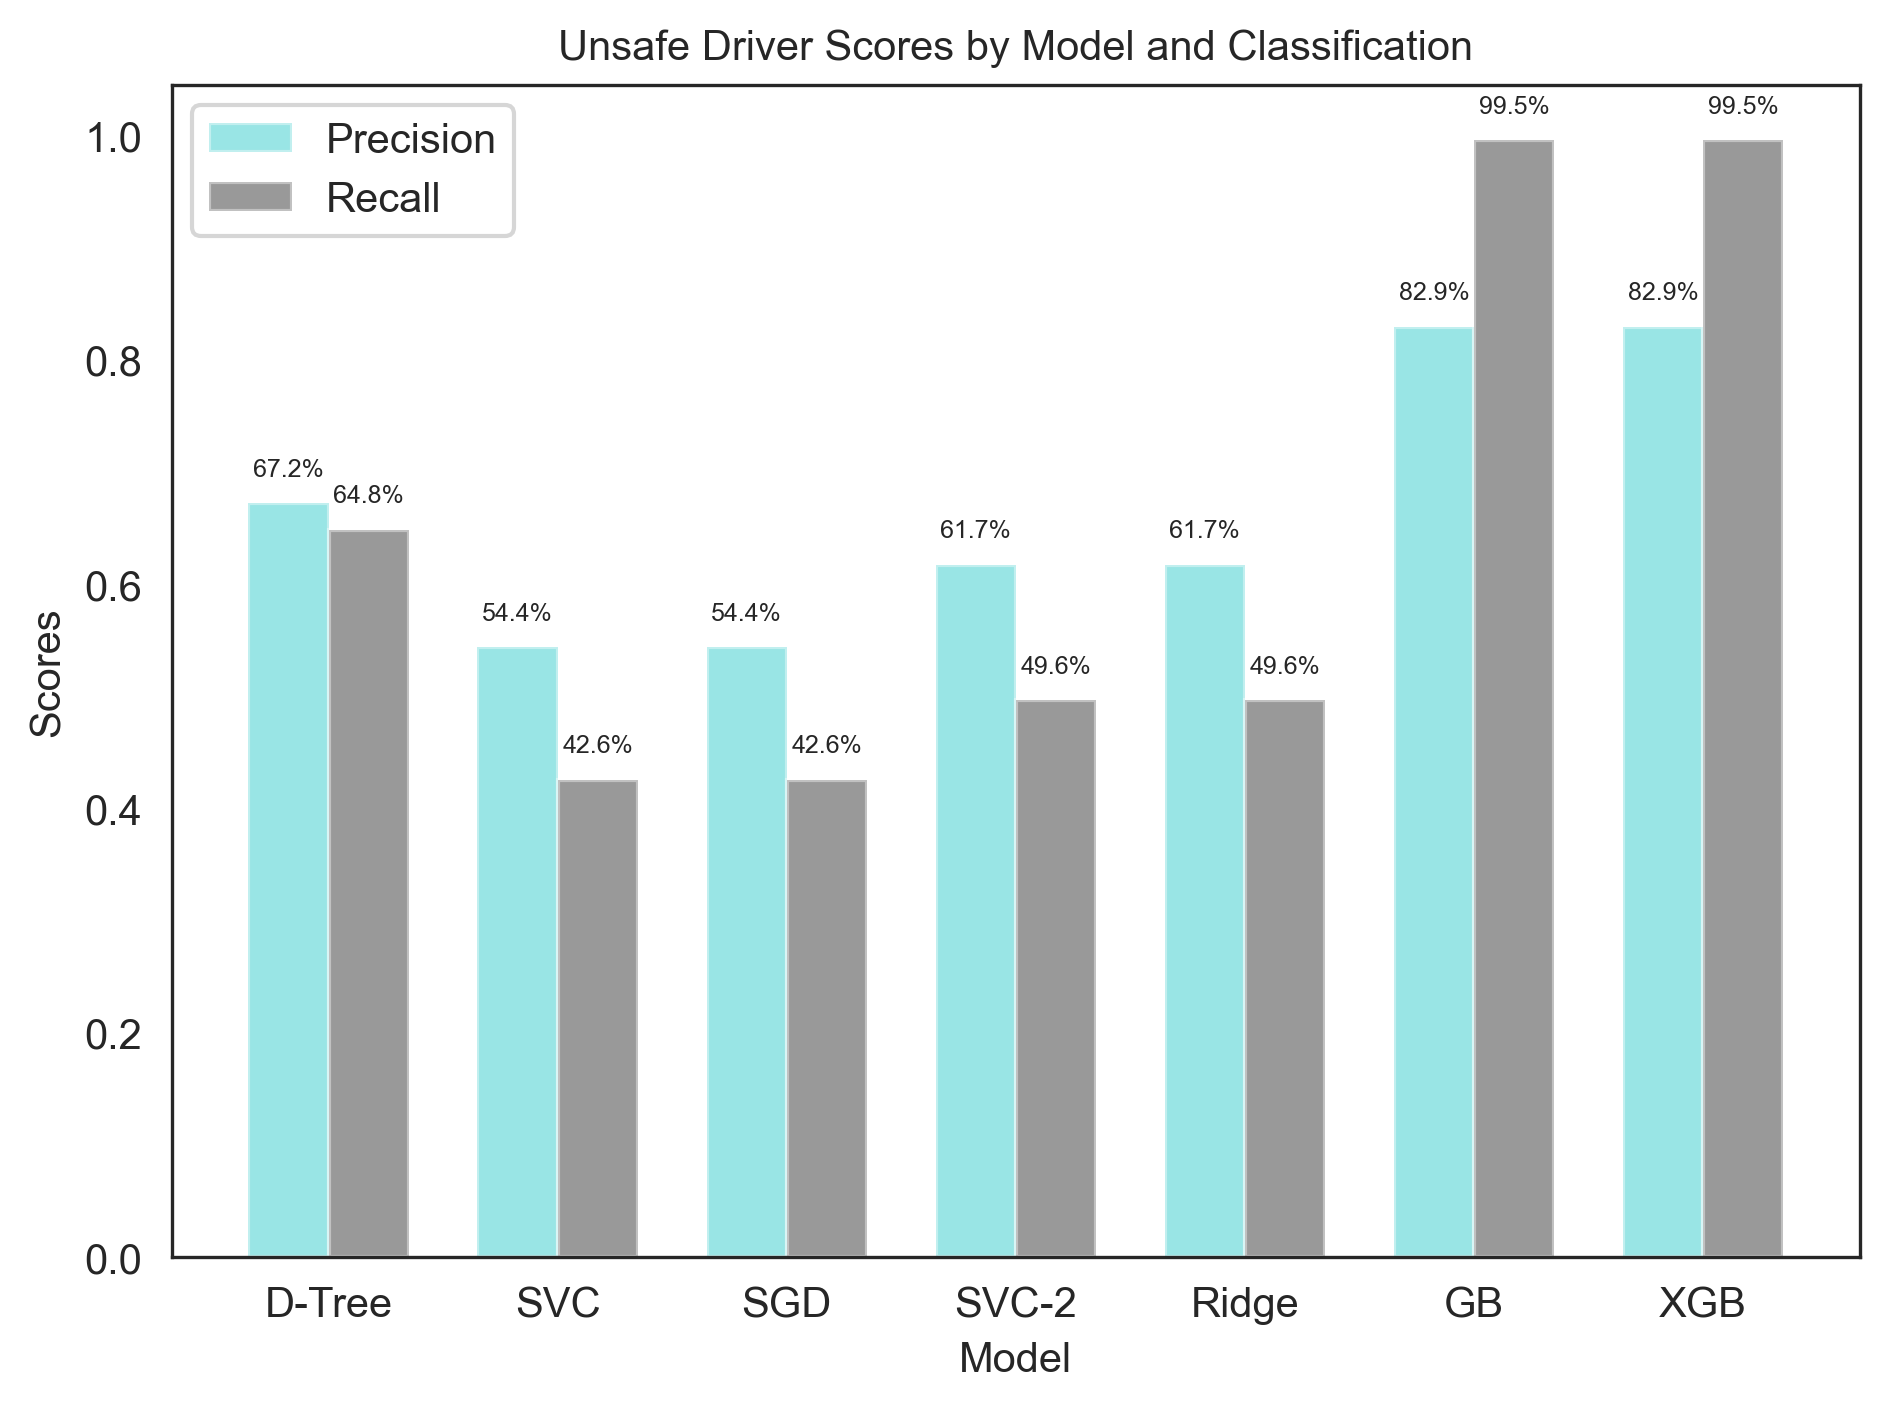

In [97]:
# Collect all the Classification Scores and plot results as a bargraph to compare performances of different models

# This plot is for Unsafe Driver Class. Values plotted are the precision and recall scores.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator  # Correct import
from collections import namedtuple

mpl.rcParams["figure.dpi"] = 300

n_groups = 7

# Sample data (Replace these with your actual data)
precision = (decision_tree["Unsafe Driver"]["precision"],
             svc_scores["Unsafe Driver"]["precision"],
             sgd_scores["Unsafe Driver"]["precision"],
             svc_2_scores["Unsafe Driver"]["precision"],
             ridge_scores["Unsafe Driver"]["precision"],
             GB_scores["Unsafe Driver"]["precision"],
             XGB_scores["Unsafe Driver"]["precision"])

recall = (decision_tree["Unsafe Driver"]["recall"],
          svc_scores["Unsafe Driver"]["recall"],
          sgd_scores["Unsafe Driver"]["recall"],
          svc_2_scores["Unsafe Driver"]["recall"],
          ridge_scores["Unsafe Driver"]["recall"],
          GB_scores["Unsafe Driver"]["recall"],
          XGB_scores["Unsafe Driver"]["recall"])

# Create the figure and axis
fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {"ecolor": "0.3"}

# Create bars for precision and recall
rects1 = ax.bar(index, precision, bar_width, alpha=opacity, color='c', error_kw=error_config, label="Precision")
rects2 = ax.bar(index + bar_width, recall, bar_width, alpha=opacity, color='k', error_kw=error_config, label="Recall")

# Add percentage labels on top of each bar
for rect in rects1:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height*100:.1f}%', ha='center', va='bottom', fontsize=6)

for rect in rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height*100:.1f}%', ha='center', va='bottom', fontsize=6)


# Set labels, title, and ticks
ax.set_xlabel("Model", fontsize=10)
ax.set_ylabel("Scores", fontsize=10)
ax.set_title("Unsafe Driver Scores by Model and Classification", fontsize=10)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(("D-Tree", "SVC", "SGD", "SVC-2", "Ridge", "GB", "XGB"), fontsize=10)

# Add a legend
ax.legend()

# Layout adjustment and saving
fig.tight_layout()
plt.savefig("Unsafe_Driver_Bargraph_200.png", dpi=200, transparent=True)

# Show the plot
plt.show()


### **Cross Validation**

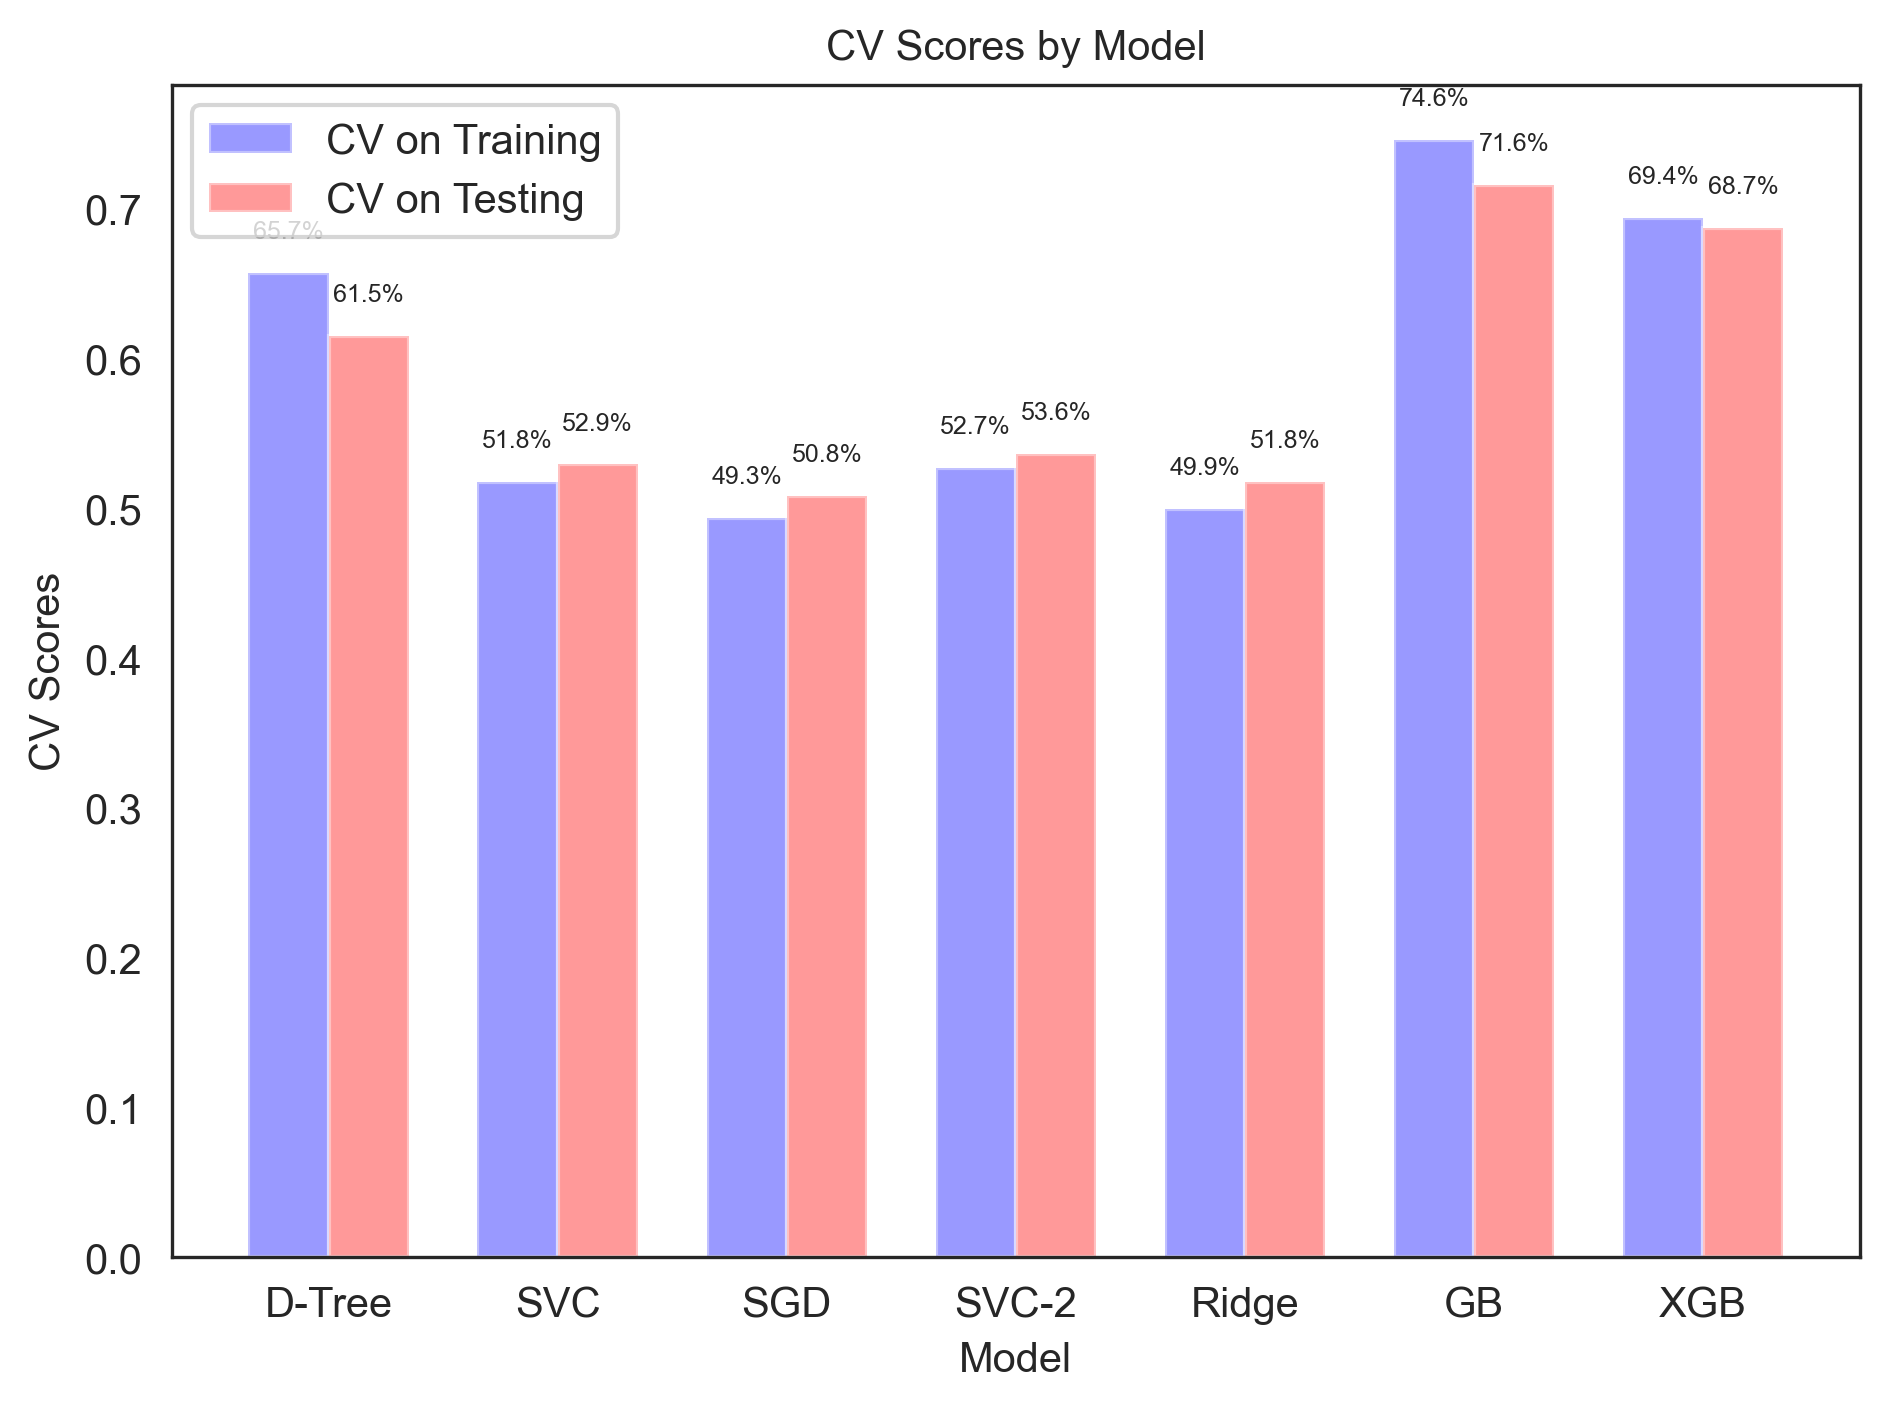

In [98]:
# Cross Validation scores that can be plotted for visuals
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator 
from collections import namedtuple

mpl.rcParams["figure.dpi"] = 300
n_groups = 7

cv_train = (dt_train_scores[0],
             svc_train_scores[0],
             sgd_train_score[0],
             svc_2_train_score[0],
             ridge_train_score[0],
             GB_train_score[0],
             XGB_train_score[0])

cv_test = (dt_test_scores[0],
          svc_test_scores[0],
          sgd_test_score[0],
          svc_2_test_score[0],
          ridge_test_score[0],
          GB_test_score[0],
          XGB_test_score[0])

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {"ecolor": "0.3"}


rects1 = ax.bar(index, cv_train, bar_width, alpha=opacity, color='b', error_kw=error_config, label="CV on Training")
rects2 = ax.bar(index + bar_width, cv_test, bar_width, alpha=opacity, color='r', error_kw=error_config, label="CV on Testing")

# Add percentage labels on top of each bar
for rect in rects1:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height*100:.1f}%', ha='center', va='bottom', fontsize=6)

for rect in rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height*100:.1f}%', ha='center', va='bottom', fontsize=6)


ax.set_xlabel("Model", fontsize=10)
ax.set_ylabel("CV Scores", fontsize=10)
ax.set_title("CV Scores by Model", fontsize=10)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(("D-Tree", "SVC", "SGD", "SVC-2", "Ridge", "GB", "XGB"), fontsize=10)

ax.legend()

fig.tight_layout()
plt.savefig("CV_Scores.png", dpi=200, transparent=True)

plt.show()